In [10]:
data_root_path = '../../data/Disease_classification_loo/'
figure_root_path = './Figures/'

# 数据过滤与数据清洗

In [ ]:
import os
import glob
import biom
import shutil
from biom import load_table, Table

# 配置路径
data_root = "Data/disease_data_raw"
output_root = "Data/disease_data"

def filter_low_freq_feature(current_table):
  print(f"过滤低频样本和特征，当前维度: {current_table.shape}")
  sid = current_table.ids(axis="sample")
  reads_depth = current_table.sum(axis="sample")
  current_table = current_table.filter(
      sid[reads_depth > 5000], axis='sample', inplace=False).remove_empty()

  fid = current_table.ids(axis="observation")
  prevalence = current_table.nonzero_counts(axis="observation")
  current_table = current_table.filter(
      fid[prevalence > 2], axis='observation', inplace=False).remove_empty()
  print(f"过滤低频样本和特征，处理后的维度: {current_table.shape}")
  return current_table

def test_to_aligment_train(test_table, train_tables):
  # print(test_table.shape)
  # print(train_tables.shape)
  # 训练集去空处理，测试集跟训练集进行维度对齐

  # 获取训练集的所有特征ID，重新索引测试表的行（特征）以匹配训练集，缺失的特征填充0
  train_features = train_tables.ids(axis='observation')
  test_df = test_table.to_dataframe()
  test_df = test_df.reindex(index=train_features, fill_value=0)

  # 创建新的BIOM表，确保特征顺序与训练集一致，过滤掉测试集中不在训练集中的 feature
  test_table = Table(
      data=test_df.values,
      observation_ids=test_df.index.tolist(),
      sample_ids=test_df.columns.tolist(),
      # observation_metadata=None,  # 可根据需要添加metadata处理
      # sample_metadata=test_table.metadata(axis='sample')
  )

  print(f"测试集样本数: {test_table.shape[1]}, 特征数: {test_table.shape[0]},训练集样本数: {train_tables.shape[1]}, 特征数: {train_tables.shape[0]}")

  return test_table,train_tables


for disease_id in os.listdir(data_root):
  disease_dir = os.path.join(data_root, disease_id)
  output_disease_dir = os.path.join(output_root, disease_id)

  # 跳过非目录和隐藏目录
  if not os.path.isdir(disease_dir) or disease_id.startswith('.'):
      continue

  # 获取所有研究数据文件
  all_bioms = glob.glob(os.path.join(disease_dir, "*.biom"))
  
  # 执行留一法拆分
  for leave_path in all_bioms:
    study_code = os.path.splitext(os.path.basename(leave_path))[0]
    output_study_dir = os.path.join(output_disease_dir, study_code)

    os.makedirs(output_study_dir, exist_ok=True)

    # 拷贝元数据文件（新增部分）
    src_metadata = os.path.join(disease_dir, "metadata.tsv")
    dst_metadata = os.path.join(output_disease_dir, "metadata.tsv")
    if os.path.exists(src_metadata):
        os.makedirs(output_disease_dir, exist_ok=True)
        shutil.copy2(src_metadata, dst_metadata)
    else:
        print(f"警告：{disease_id} 缺失元数据文件")
    


    # 构建训练集
    train_tables = []
    for train_path in all_bioms:
        if train_path == leave_path:
            continue
        try:
          train_study_code = os.path.splitext(os.path.basename(train_path))[0]
          
          print(f"加载数据集 {train_path}:")
          current_table = load_table(train_path)
          train_tables.append(current_table)
        except Exception as e:
            print(f"加载失败 {train_path}: {str(e)}")
            continue
    
    # 合并训练数据
    if not train_tables:
        print(f"警告：{disease_id} 只有一个样本，无法进行留一法拆分")
        continue

    merged_train = filter_low_freq_feature(train_tables[0]) 
    for tbl in train_tables[1:]:
        tbl = filter_low_freq_feature(tbl)
        merged_train = merged_train.merge(tbl)
    merged_train = merged_train.remove_empty()
    # 保存测试集副本
    test_table = load_table(leave_path)
    test_table = filter_low_freq_feature(test_table)

    test_table, merged_train = test_to_aligment_train(test_table, merged_train)

    # if os.path.exists(output_study_dir):
    #   shutil.rmtree(output_study_dir)
    #   print(f"已删除旧目录: {output_study_dir}")

    with biom.util.biom_open(f'{output_study_dir}/train_loo.biom', 'w') as f:
      merged_train.to_hdf5(f, "train")
    with biom.util.biom_open(f'{output_study_dir}/test_loo.biom', 'w') as f:
      test_table.to_hdf5(f, "test")

print("Processing completed with biom library integration.")

## 拼接所有的疾病数据

In [18]:
import os
import pandas as pd
import biom
from tqdm import tqdm
import sys

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
BASE_DIR = 'Data/disease_data_raw/'
OUTPUT_DIR = 'Data/loo_all_diseases/'
EXCLUDED_DISEASES = {'IBD'}
OUTPUT_METADATA_FILENAME = 'all_diseases_metadata.tsv'
OUTPUT_BIOM_FILENAME = 'all_diseases.biom'


# ==============================================================================
# --- 2. HELPER FUNCTIONS ---
# ==============================================================================

def filter_low_freq_feature(current_table: biom.Table) -> biom.Table:
    """
    Filters a BIOM table to remove low-depth samples and low-prevalence features.
    """
    print(f"    > Filtering table. Initial shape: {current_table.shape}")
    sids_to_keep = current_table.ids('sample')[current_table.sum('sample') > 5000]
    if len(sids_to_keep) < len(current_table.ids('sample')):
        current_table = current_table.filter(sids_to_keep, axis='sample', inplace=False)
    
    fids_to_keep = current_table.ids('observation')[current_table.nonzero_counts('observation') > 2]
    if len(fids_to_keep) < len(current_table.ids('observation')):
        current_table = current_table.filter(fids_to_keep, axis='observation', inplace=False)
        
    current_table.remove_empty()
    print(f"    > Filtering complete. Final shape: {current_table.shape}")
    return current_table

def process_single_disease(disease_path: str, disease_name: str):
    """
    Loads, filters, merges, and intersects data for a single disease.
    Returns a tuple of (filtered_biom_table, filtered_metadata_df) or (None, None) on failure.
    """
    print(f"\n--- Processing Disease: {disease_name} ---")

    # 1. Load Metadata
    metadata_path = os.path.join(disease_path, 'metadata.tsv')
    if not os.path.exists(metadata_path):
        print(f"  ! Warning: metadata.tsv not found for {disease_name}. Skipping this disease.")
        return None, None
    try:
        df_meta = pd.read_csv(metadata_path, sep='\t', header=0)
        if 'project' in df_meta.columns and 'study' not in df_meta.columns:
            df_meta.rename(columns={'project': 'study'}, inplace=True)
    except Exception as e:
        print(f"  ! Warning: Could not load metadata for {disease_name}. Error: {e}. Skipping.")
        return None, None

    # 2. Load and Filter all BIOM tables for this disease
    biom_files = [f for f in os.listdir(disease_path) if f.endswith('.biom')]
    if not biom_files:
        print(f"  ! Warning: No .biom files found for {disease_name}. Skipping.")
        return None, None
        
    disease_specific_tables = []
    for biom_filename in biom_files:
        biom_path = os.path.join(disease_path, biom_filename)
        print(f"  - Loading BIOM table: {biom_filename}")
        try:
            table = biom.load_table(biom_path)
            print(f"    > Initial sample count: {table.shape[1]}")
            filtered_table = filter_low_freq_feature(table)
            if filtered_table.shape[0] > 0 and filtered_table.shape[1] > 0:
                disease_specific_tables.append(filtered_table)
        except Exception as e:
            print(f"  ! Error loading or filtering {biom_filename}. Error: {e}")

    if not disease_specific_tables:
        print(f"  ! Warning: No valid BIOM data for {disease_name} after filtering. Skipping.")
        return None, None

    # 3. Merge all BIOMs for this single disease
    if len(disease_specific_tables) > 1:
        print(f"  - Merging {len(disease_specific_tables)} BIOM tables for {disease_name}...")
        merged_disease_biom = disease_specific_tables[0]
        for table in disease_specific_tables[1:]:
            merged_disease_biom = merged_disease_biom.merge(table)
    else:
        merged_disease_biom = disease_specific_tables[0]
    print(f"  - Merged BIOM shape for {disease_name}: {merged_disease_biom.shape}")

    # 4. Intersect this disease's BIOM and Metadata
    biom_ids = set(merged_disease_biom.ids('sample'))
    
    if '#SampleID' in df_meta.columns:
        sample_id_col = '#SampleID'
    elif 'sample' in df_meta.columns:
        sample_id_col = 'sample'
    else:
        print(f"  ! Error: No '#SampleID' or 'sample' column in metadata for {disease_name}. Skipping.")
        return None, None
    meta_ids = set(df_meta[sample_id_col])

    # Calculate and report missing samples statistics
    missing_in_meta = biom_ids - meta_ids
    missing_count = len(missing_in_meta)
    total_biom_samples = len(biom_ids)
    missing_percentage = (missing_count / total_biom_samples) * 100 if total_biom_samples > 0 else 0
    
    print(f"  ⚠️ Sample Matching Report for {disease_name}:")
    print(f"     - Total samples in BIOM: {total_biom_samples}")
    print(f"     - Samples missing from metadata: {missing_count} ({missing_percentage:.2f}%)")
    if missing_in_meta:
        print(f"     - First 5 missing sample IDs: {list(missing_in_meta)[:5]}")

    common_ids = list(biom_ids.intersection(meta_ids))
    if not common_ids:
        print(f"  ! Error: No common samples between BIOM and metadata for {disease_name}. Skipping.")
        return None, None

    # 5. Filter to common samples
    final_disease_biom = merged_disease_biom.filter(common_ids, axis='sample', inplace=False)
    final_disease_meta = df_meta[df_meta[sample_id_col].isin(common_ids)].copy()
    
    print(f"  - Intersection complete for {disease_name}. Keeping {len(common_ids)} common samples.")
    return final_disease_biom, final_disease_meta


# ==============================================================================
# --- 3. MAIN SCRIPT LOGIC ---
# ==============================================================================

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output will be saved to: {OUTPUT_DIR}\n")

    try:
        all_folders = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
        disease_folders_to_process = [d for d in all_folders if d not in EXCLUDED_DISEASES]
        if not disease_folders_to_process:
            print("No disease folders found to process after exclusions. Exiting.")
            return
    except FileNotFoundError:
        print(f"Error: Base directory not found at '{BASE_DIR}'. Please check the path.")
        return

    print(f"Found {len(disease_folders_to_process)} diseases to process: {', '.join(disease_folders_to_process)}")
    print(f"Excluding {len(EXCLUDED_DISEASES)} diseases: {', '.join(EXCLUDED_DISEASES)}")

    all_clean_metadata_dfs = []
    all_clean_biom_tables = []

    # --- Step 1: Process each disease folder individually ---
    for disease_name in tqdm(disease_folders_to_process, desc="Overall Progress"):
        disease_path = os.path.join(BASE_DIR, disease_name)
        
        # This function does all the heavy lifting for one disease
        clean_biom, clean_meta = process_single_disease(disease_path, disease_name)
        
        if clean_biom is not None and clean_meta is not None:
            all_clean_biom_tables.append(clean_biom)
            all_clean_metadata_dfs.append(clean_meta)

    # --- Step 2: Merge all the cleaned-up data ---
    print("\n--- Final Merging Step ---")

    if all_clean_metadata_dfs:
        print(f"Merging metadata from {len(all_clean_metadata_dfs)} clean disease datasets...")
        final_metadata_df = pd.concat(all_clean_metadata_dfs, ignore_index=True)
        if 'sample' in final_metadata_df.columns:
             final_metadata_df.rename(columns={'sample': 'sample'}, inplace=True)
        output_meta_path = os.path.join(OUTPUT_DIR, OUTPUT_METADATA_FILENAME)
        final_metadata_df.to_csv(output_meta_path, sep='\t', index=False)
        print(f"✅ Combined metadata saved to: {output_meta_path}")
    else:
        print("No metadata to merge.")

    if len(all_clean_biom_tables) > 1:
        print(f"Merging {len(all_clean_biom_tables)} clean BIOM tables...")
        master_table = all_clean_biom_tables[0]
        for table in tqdm(all_clean_biom_tables[1:], desc="Merging BIOMs"):
            master_table = master_table.merge(table)
        print(f"Final merged BIOM table shape: {master_table.shape}")
        output_biom_path = os.path.join(OUTPUT_DIR, OUTPUT_BIOM_FILENAME)
        with biom.util.biom_open(output_biom_path, 'w') as f:
            master_table.to_hdf5(f, "Merged by script")
        print(f"✅ Combined BIOM table saved to: {output_biom_path}")
    elif len(all_clean_biom_tables) == 1:
        # Just save the single clean table
        output_biom_path = os.path.join(OUTPUT_DIR, OUTPUT_BIOM_FILENAME)
        with biom.util.biom_open(output_biom_path, 'w') as f:
             all_clean_biom_tables[0].to_hdf5(f, "Processed by script")
        print(f"✅ Single BIOM table saved to: {output_biom_path}")
    else:
        print("No BIOM tables to merge.")

    print("\nProcessing complete.")

if __name__ == '__main__':
    main()

Output will be saved to: Data/loo_all_diseases/

Found 12 diseases to process: CAD, OB, IBS, SZ, BD, AS, PD, GD, MS, T2DM, CRC, ASD
Excluding 1 diseases: IBD


Overall Progress:   0%|          | 0/12 [00:00<?, ?it/s]


--- Processing Disease: CAD ---
  - Loading BIOM table: PRJDB7456.biom
    > Initial sample count: 63
    > Filtering table. Initial shape: (14116, 63)
    > Filtering complete. Final shape: (882, 63)
  - Loading BIOM table: PRJDB6472.biom
    > Initial sample count: 52
    > Filtering table. Initial shape: (14116, 52)


Overall Progress:   8%|▊         | 1/12 [00:01<00:17,  1.57s/it]

    > Filtering complete. Final shape: (353, 52)
  - Merging 2 BIOM tables for CAD...
  - Merged BIOM shape for CAD: (1112, 115)
  ⚠️ Sample Matching Report for CAD:
     - Total samples in BIOM: 115
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for CAD. Keeping 115 common samples.

--- Processing Disease: OB ---
  - Loading BIOM table: PRJEB11419.biom
    > Initial sample count: 699
    > Filtering table. Initial shape: (14116, 699)
    > Filtering complete. Final shape: (2153, 699)
  - Loading BIOM table: PRJEB28687.biom
    > Initial sample count: 509
    > Filtering table. Initial shape: (14116, 509)
    > Filtering complete. Final shape: (1072, 509)
  - Merging 2 BIOM tables for OB...


Overall Progress:  17%|█▋        | 2/12 [00:04<00:22,  2.28s/it]

  - Merged BIOM shape for OB: (2383, 1208)
  ⚠️ Sample Matching Report for OB:
     - Total samples in BIOM: 1208
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for OB. Keeping 1208 common samples.

--- Processing Disease: IBS ---
  - Loading BIOM table: PRJEB11419.biom
    > Initial sample count: 846
    > Filtering table. Initial shape: (14116, 846)
    > Filtering complete. Final shape: (2281, 846)
  - Loading BIOM table: PRJNA268708.biom
    > Initial sample count: 288
    > Filtering table. Initial shape: (14116, 288)
    > Filtering complete. Final shape: (1576, 288)
  - Merging 2 BIOM tables for IBS...


Overall Progress:  25%|██▌       | 3/12 [00:07<00:24,  2.76s/it]

  - Merged BIOM shape for IBS: (2481, 1134)
  ⚠️ Sample Matching Report for IBS:
     - Total samples in BIOM: 1134
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for IBS. Keeping 1134 common samples.

--- Processing Disease: SZ ---
  - Loading BIOM table: PRJNA896324.biom
    > Initial sample count: 61
    > Filtering table. Initial shape: (2274, 61)
    > Filtering complete. Final shape: (1055, 60)
  - Loading BIOM table: PRJNA807473.biom
    > Initial sample count: 161
    > Filtering table. Initial shape: (2842, 161)
    > Filtering complete. Final shape: (1209, 161)
  - Loading BIOM table: PRJNA880407.biom
    > Initial sample count: 100
    > Filtering table. Initial shape: (14116, 100)
    > Filtering complete. Final shape: (1076, 100)
  - Loading BIOM table: PRJCA000673.biom
    > Initial sample count: 117
    > Filtering table. Initial shape: (14116, 117)
    > Filtering complete. Final shape: (1204, 117)
  - Merging 4 BIOM tables for SZ...


Overall Progress:  33%|███▎      | 4/12 [00:10<00:23,  2.89s/it]

  - Merged BIOM shape for SZ: (2322, 438)
  ⚠️ Sample Matching Report for SZ:
     - Total samples in BIOM: 438
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for SZ. Keeping 438 common samples.

--- Processing Disease: BD ---
  - Loading BIOM table: PRJEB23500.biom
    > Initial sample count: 119
    > Filtering table. Initial shape: (14116, 119)
    > Filtering complete. Final shape: (730, 119)
  - Loading BIOM table: PRJNA1068750.biom
    > Initial sample count: 88
    > Filtering table. Initial shape: (14116, 88)
    > Filtering complete. Final shape: (609, 88)
  - Loading BIOM table: PRJEB11419.biom
    > Initial sample count: 30
    > Filtering table. Initial shape: (14116, 30)
    > Filtering complete. Final shape: (572, 30)
  - Merging 3 BIOM tables for BD...


Overall Progress:  42%|████▏     | 5/12 [00:13<00:19,  2.79s/it]

  - Merged BIOM shape for BD: (1368, 237)
  ⚠️ Sample Matching Report for BD:
     - Total samples in BIOM: 237
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for BD. Keeping 237 common samples.

--- Processing Disease: AS ---
  - Loading BIOM table: PRJCA007396.biom
    > Initial sample count: 59
    > Filtering table. Initial shape: (14116, 59)
    > Filtering complete. Final shape: (780, 59)
  - Loading BIOM table: SRP332779.biom
    > Initial sample count: 84
    > Filtering table. Initial shape: (14116, 84)
    > Filtering complete. Final shape: (487, 84)
  - Merging 2 BIOM tables for AS...


Overall Progress:  50%|█████     | 6/12 [00:15<00:14,  2.47s/it]

  - Merged BIOM shape for AS: (1037, 143)
  ⚠️ Sample Matching Report for AS:
     - Total samples in BIOM: 143
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for AS. Keeping 143 common samples.

--- Processing Disease: PD ---
  - Loading BIOM table: PRJEB30615.biom
    > Initial sample count: 256
    > Filtering table. Initial shape: (2056, 256)
    > Filtering complete. Final shape: (1393, 255)
  - Loading BIOM table: PRJNA742875.biom
    > Initial sample count: 171
    > Filtering table. Initial shape: (3344, 171)
    > Filtering complete. Final shape: (1437, 171)
  - Loading BIOM table: PRJNA510730.biom
    > Initial sample count: 201
    > Filtering table. Initial shape: (14116, 201)
    > Filtering complete. Final shape: (1624, 201)
  - Loading BIOM table: PRJEB27564.biom
    > Initial sample count: 265
    > Filtering table. Initial shape: (9728, 265)
    > Filtering complete. Final shape: (5514, 253)
  - Loading BIOM table: PRJNA594156.biom
    > Init

Overall Progress:  58%|█████▊    | 7/12 [00:26<00:27,  5.49s/it]

  - Merged BIOM shape for PD: (7908, 1495)
  ⚠️ Sample Matching Report for PD:
     - Total samples in BIOM: 1495
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for PD. Keeping 1495 common samples.

--- Processing Disease: GD ---
  - Loading BIOM table: PRJNA695309.biom
    > Initial sample count: 103
    > Filtering table. Initial shape: (14116, 103)
    > Filtering complete. Final shape: (991, 103)
  - Loading BIOM table: PRJNA850658.biom
    > Initial sample count: 98
    > Filtering table. Initial shape: (14116, 98)


Overall Progress:  67%|██████▋   | 8/12 [00:28<00:17,  4.27s/it]

    > Filtering complete. Final shape: (569, 98)
  - Merging 2 BIOM tables for GD...
  - Merged BIOM shape for GD: (1086, 201)
  ⚠️ Sample Matching Report for GD:
     - Total samples in BIOM: 201
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for GD. Keeping 201 common samples.

--- Processing Disease: MS ---
  - Loading BIOM table: PRJEB22977.biom
    > Initial sample count: 87
    > Filtering table. Initial shape: (14116, 87)
    > Filtering complete. Final shape: (1401, 87)
  - Loading BIOM table: PRJEB22970.biom
    > Initial sample count: 110
    > Filtering table. Initial shape: (14116, 110)
    > Filtering complete. Final shape: (1199, 110)
  - Loading BIOM table: PRJEB32763.biom
    > Initial sample count: 134
    > Filtering table. Initial shape: (14116, 134)
    > Filtering complete. Final shape: (1436, 134)
  - Merging 3 BIOM tables for MS...


Overall Progress:  75%|███████▌  | 9/12 [00:31<00:11,  4.00s/it]

  - Merged BIOM shape for MS: (3185, 331)
  ⚠️ Sample Matching Report for MS:
     - Total samples in BIOM: 331
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for MS. Keeping 331 common samples.

--- Processing Disease: T2DM ---
  - Loading BIOM table: PRJNA978958.biom
    > Initial sample count: 29
    > Filtering table. Initial shape: (14116, 29)
    > Filtering complete. Final shape: (513, 29)
  - Loading BIOM table: PRJNA646010.biom
    > Initial sample count: 41
    > Filtering table. Initial shape: (14116, 41)
    > Filtering complete. Final shape: (491, 41)
  - Loading BIOM table: PRJNA788301.biom
    > Initial sample count: 51
    > Filtering table. Initial shape: (14116, 51)
    > Filtering complete. Final shape: (415, 51)
  - Loading BIOM table: PRJNA766337.biom
    > Initial sample count: 497
    > Filtering table. Initial shape: (14116, 497)
    > Filtering complete. Final shape: (2149, 497)
  - Loading BIOM table: PRJEB11419.biom
    > Initial sa

Overall Progress:  83%|████████▎ | 10/12 [00:54<00:19,  9.67s/it]

  - Merged BIOM shape for T2DM: (4026, 1189)
  ⚠️ Sample Matching Report for T2DM:
     - Total samples in BIOM: 1189
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for T2DM. Keeping 1189 common samples.

--- Processing Disease: CRC ---
  - Loading BIOM table: PRJEB36789.biom
    > Initial sample count: 153
    > Filtering table. Initial shape: (14116, 153)
    > Filtering complete. Final shape: (1495, 153)
  - Loading BIOM table: PRJNA430990.biom
    > Initial sample count: 146
    > Filtering table. Initial shape: (14116, 146)
    > Filtering complete. Final shape: (1070, 146)
  - Loading BIOM table: PRJNA290926.biom
    > Initial sample count: 255
    > Filtering table. Initial shape: (14116, 255)
    > Filtering complete. Final shape: (1358, 255)
  - Loading BIOM table: PRJDB11845.biom
    > Initial sample count: 102
    > Filtering table. Initial shape: (14116, 102)
    > Filtering complete. Final shape: (1449, 102)
  - Loading BIOM table: PRJNA318004.bi

Overall Progress:  92%|█████████▏| 11/12 [01:06<00:10, 10.49s/it]

  - Merged BIOM shape for CRC: (4600, 1034)
  ⚠️ Sample Matching Report for CRC:
     - Total samples in BIOM: 1034
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for CRC. Keeping 1034 common samples.

--- Processing Disease: ASD ---
  - Loading BIOM table: PRJNA932561.biom
    > Initial sample count: 80
    > Filtering table. Initial shape: (14116, 80)
    > Filtering complete. Final shape: (986, 80)
  - Loading BIOM table: PRJNA1103839.biom
    > Initial sample count: 61
    > Filtering table. Initial shape: (14116, 61)
    > Filtering complete. Final shape: (821, 61)
  - Loading BIOM table: PRJNA578223.biom
    > Initial sample count: 96
    > Filtering table. Initial shape: (14116, 96)
    > Filtering complete. Final shape: (575, 96)
  - Merging 3 BIOM tables for ASD...


Overall Progress: 100%|██████████| 12/12 [01:09<00:00,  5.80s/it]


  - Merged BIOM shape for ASD: (1639, 237)
  ⚠️ Sample Matching Report for ASD:
     - Total samples in BIOM: 237
     - Samples missing from metadata: 0 (0.00%)
  - Intersection complete for ASD. Keeping 237 common samples.

--- Final Merging Step ---
Merging metadata from 12 clean disease datasets...
✅ Combined metadata saved to: Data/loo_all_diseases/all_diseases_metadata.tsv
Merging 12 clean BIOM tables...


Merging BIOMs: 100%|██████████| 11/11 [01:09<00:00,  6.28s/it]


Final merged BIOM table shape: (11467, 7762)
✅ Combined BIOM table saved to: Data/loo_all_diseases/all_diseases.biom

Processing complete.


## 拼接过滤好的IBD的数据，粪便

In [20]:
import os
import pandas as pd
import biom
import sys

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
TOTAL_DATA_DIR = 'Data/loo_all_diseases/'
TOTAL_BIOM_PATH = os.path.join(TOTAL_DATA_DIR, 'all_diseases.biom')
TOTAL_METADATA_PATH = os.path.join(TOTAL_DATA_DIR, 'all_diseases_metadata.tsv')

IBD_BIOM_PATH = 'Data/loo_all_diseases/IBD_filter_table.biom'
IBD_METADATA_PATH = 'Data/loo_all_diseases/IBD_filter_metadata.tsv'

OUTPUT_DIR = 'Data/loo_all_diseases'

# --- Final, clean output files (only common samples) ---
FINAL_INTERSECTED_BIOM_FILENAME = 'total_plus_IBD_final.biom'
FINAL_INTERSECTED_METADATA_FILENAME = 'total_plus_IBD_final_metadata.tsv'

# --- New diagnostic file showing all samples and their metadata status ---
COMPREHENSIVE_METADATA_LOG_FILENAME = 'diagnostics_comprehensive_metadata.csv'


# ==============================================================================
# --- 2. INTERSECTION AND LOGGING FUNCTION ---
# ==============================================================================

def intersect_and_save(biom_table, metadata_df, final_biom_path, final_metadata_path):
    """
    Finds common samples, logs a comprehensive metadata file for inspection,
    filters the data, and saves the final clean files.
    """
    print("\n--- Starting Intersection and Diagnostic Step ---")

    print("3. Extracting sample IDs...")
    biom_sample_ids = set(biom_table.ids(axis='sample'))

    # Find the sample ID column in the metadata
    if '#SampleID' in metadata_df.columns:
        sample_id_col = '#SampleID'
    elif 'sample' in metadata_df.columns:
        sample_id_col = 'sample'
    else:
        print("❌ ERROR: Could not find a sample ID column ('#SampleID' or 'sample') in the metadata.")
        print("         Attempting to use the first column as sample ID.")
        sample_id_col = metadata_df.columns[0]
        metadata_df.rename(columns={sample_id_col: '#SampleID'}, inplace=True)
        sample_id_col = '#SampleID'
        
    metadata_sample_ids = set(metadata_df[sample_id_col])

    print(f"   - Found {len(biom_sample_ids)} unique samples in merged BIOM table.")
    print(f"   - Found {len(metadata_sample_ids)} unique samples in merged metadata.")

    # --- ### MODIFIED: Create and save a comprehensive metadata file for inspection ### ---
    print("\n4. Creating a comprehensive metadata file for diagnostics...")
    
    # Create a DataFrame with all sample IDs from the BIOM file
    biom_ids_df = pd.DataFrame(list(biom_sample_ids), columns=[sample_id_col])

    # Perform a 'left' merge. This keeps every sample from the BIOM file.
    # If a sample has metadata, it will be merged. If not, its metadata columns will be NaN (blank).
    comprehensive_df = pd.merge(biom_ids_df, metadata_df, on=sample_id_col, how='left')
    
    # Save the comprehensive diagnostic file
    comprehensive_log_path = os.path.join(OUTPUT_DIR, COMPREHENSIVE_METADATA_LOG_FILENAME)
    comprehensive_df.to_csv(comprehensive_log_path, index=False)
    
    print(f"✅ A comprehensive metadata file has been saved for your review at:")
    print(f"   {comprehensive_log_path}")
    print("   (In this file, rows with empty data are samples missing from the original metadata)")
    # --- ### END OF MODIFICATION ### ---

    # --- Now, continue with the original intersection logic to create the final clean files ---
    common_samples = biom_sample_ids.intersection(metadata_sample_ids)
    if not common_samples:
        print("\n❌ ERROR: No common samples found. Cannot create final analysis files.")
        sys.exit(1)
    print(f"\n   - Found {len(common_samples)} samples present in BOTH files. These will be kept for the final output.")

    print("\n5. Filtering data to create final, clean analysis files...")
    common_samples_list = list(common_samples)
    
    filtered_biom = biom_table.filter(common_samples_list, axis='sample', inplace=False)
    filtered_metadata = metadata_df[metadata_df[sample_id_col].isin(common_samples_list)].copy()

    print(f"   - Final BIOM table shape for analysis: {filtered_biom.shape}")
    print(f"   - Final metadata shape for analysis: {filtered_metadata.shape}")

    print("\n6. Saving final intersected files for analysis...")
    
    with biom.util.biom_open(final_biom_path, 'w') as f:
        filtered_biom.to_hdf5(f, "Merged and Intersected for Analysis")
    print(f"✅ Final clean BIOM table saved to: {final_biom_path}")

    filtered_metadata.to_csv(final_metadata_path, sep='\t', index=False)
    print(f"✅ Final clean metadata saved to: {final_metadata_path}")


# ==============================================================================
# --- 3. MAIN SCRIPT LOGIC ---
# ==============================================================================

def merge_datasets():
    """
    Loads, merges, and then intersects the total dataset with the new IBD dataset.
    """
    print("--- Starting Merge Process ---")

    files_to_check = [TOTAL_BIOM_PATH, TOTAL_METADATA_PATH, IBD_BIOM_PATH, IBD_METADATA_PATH]
    for f_path in files_to_check:
        if not os.path.exists(f_path):
            print(f"❌ ERROR: Input file not found at '{f_path}'")
            print("Please check the paths in the CONFIGURATION section of the script.")
            sys.exit(1)

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output will be saved to: {OUTPUT_DIR}\n")

    try:
        print("1. Loading and merging metadata files...")
        df_total = pd.read_csv(TOTAL_METADATA_PATH, sep='\t', header=0, on_bad_lines='skip')
        df_ibd = pd.read_csv(IBD_METADATA_PATH, sep='\t', header=0, on_bad_lines='skip')
        merged_metadata_df = pd.concat([df_total, df_ibd], ignore_index=True)
        print(f"   - Merged metadata contains a total of {len(merged_metadata_df)} samples.")

        print("\n2. Loading and merging BIOM tables... (This might take a moment)")
        total_biom = biom.load_table(TOTAL_BIOM_PATH)
        ibd_biom = biom.load_table(IBD_BIOM_PATH)
        merged_biom_table = total_biom.merge(ibd_biom)
        print(f"   - Merged BIOM table shape: {merged_biom_table.shape}")

    except Exception as e:
        print(f"❌ ERROR during the merging process: {e}")
        return

    final_biom_path = os.path.join(OUTPUT_DIR, FINAL_INTERSECTED_BIOM_FILENAME)
    final_metadata_path = os.path.join(OUTPUT_DIR, FINAL_INTERSECTED_METADATA_FILENAME)
    intersect_and_save(merged_biom_table, merged_metadata_df, final_biom_path, final_metadata_path)

    print("\n--- Process Complete! ---")


if __name__ == '__main__':
    merge_datasets()

--- Starting Merge Process ---
Output will be saved to: Data/loo_all_diseases

1. Loading and merging metadata files...
   - Merged metadata contains a total of 10276 samples.

2. Loading and merging BIOM tables... (This might take a moment)
   - Merged BIOM table shape: (14019, 10276)

--- Starting Intersection and Diagnostic Step ---
3. Extracting sample IDs...
   - Found 10276 unique samples in merged BIOM table.
   - Found 10276 unique samples in merged metadata.

4. Creating a comprehensive metadata file for diagnostics...
✅ A comprehensive metadata file has been saved for your review at:
   Data/loo_all_diseases/diagnostics_comprehensive_metadata.csv
   (In this file, rows with empty data are samples missing from the original metadata)

   - Found 10276 samples present in BOTH files. These will be kept for the final output.

5. Filtering data to create final, clean analysis files...
   - Final BIOM table shape for analysis: (14019, 10276)
   - Final metadata shape for analysis: (

# 获取模型的预测结果

In [2]:
import torch
import biom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, accuracy_score
from membed.Attention_embedding import load_data_imdb, DataLoader, TransformerEncoder, evaluate_auc_gpu, set_seed

membed 0.1.0 initialized.


In [4]:
set_seed(11)
num_steps=600
p_drop=0.4
batch_size=6000
d_model=100
n_layers=1
n_heads=1
group = "group"

## 获取所有疾病的预测结果

In [7]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table

# TODO: 等待GPU资源
# import time
# from datetime import datetime
# time.sleep(1800)

# 配置路径
base_dir = "Data/disease_data"
 
# 初始化结果容器
results = {
    'disease': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr


def save_results(disease, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr):
    """保存分析结果"""
    # 保存指标
    results['disease'].append(disease)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(str(cm))  # 将矩阵转为字符串保存
    
    # 保存ROC曲线
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    output_dir = os.path.join(base_dir, disease, study, "results")
    os.makedirs(output_dir, exist_ok=True)
    roc_df.to_csv(os.path.join(output_dir, "roc_curve.csv"), index=False)
 
def process_disease(disease_path):
    """处理单个疾病目录"""
    disease_name = os.path.basename(disease_path)
    print(f"\n{'='*30}\n处理疾病: {disease_name}\n{'='*30}")
    
    # 获取所有研究目录
    study_dirs = [
        d for d in os.listdir(disease_path) 
        if os.path.isdir(os.path.join(disease_path, d))
    ]
    
    # 跳过单个研究的疾病
    if len(study_dirs) <= 1:
        print(f"!! 跳过 {disease_name}，仅有 {len(study_dirs)} 个研究")
        return
    
    # 检查元数据文件
    metadata_path = os.path.join(disease_path, "metadata.tsv")
    if not os.path.exists(metadata_path):
        print(f"!! 严重错误：{disease_name} 缺失元数据文件")
        return
    
    # 遍历每个研究
    for study in study_dirs:
        study_path = os.path.join(disease_path, study)
        print(f"\n-- 处理研究: {study}")
        
        # 验证必需文件
        required_files = {
            'train': 'train_loo.biom',
            'test': 'test_loo.biom',
            'model': os.path.join('results', 'attention_loo.pt')
        }
        
        missing_files = [
            f for f in required_files.values() 
            if not os.path.exists(os.path.join(study_path, f))
        ]
        
        if missing_files:
            print(f"!! 文件缺失: {', '.join(missing_files)}")
            continue
        
        # 加载数据
        train_data = load_data_imdb(f'{study_path}/train_loo.biom',
                                    metadata_path,
                                    group,
                                    'sample',
                                    num_steps)
        test_data = load_data_imdb(f'{study_path}/test_loo.biom',
                                        metadata_path,
                                        group,
                                        'sample',
                                        num_steps)
        
        train_iter = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        test_iter = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        table = biom.load_table(f'{study_path}/test_loo.biom')
        study_ordered_sample_ids = table.ids(axis='sample')
        
        # 加载模型
        fid_dict = train_data()
        net = TransformerEncoder(otu_size=len(fid_dict),
                                    seq_len=num_steps+1,
                                    d_model=d_model,
                                    n_layers=n_layers,
                                    n_heads=n_heads,
                                    p_drop=p_drop,
                                    pad_id=fid_dict['<pad>'])
        
        net.load_state_dict( 
                torch.load(
                    f'{study_path}/results/attention_loo.pt',
                    map_location=torch.device('cpu')))
        
        print(net.embedding)  # 确认num_embeddings参数
        
        with torch.no_grad():
            net.eval()
            for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
                pred, _ = net(features, abundance, mask)
                # print(pred)
                # 评估性能
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(group_lables, pred)
                
                pred_probabilities = torch.sigmoid(pred) 
                # print(pred_probabilities)
                if pred_probabilities.ndim > 1 and pred_probabilities.shape[1] == 1:
                    pred_probabilities = pred_probabilities.squeeze(1)
                final_true_labels = group_lables.cpu().numpy().flatten()
                final_pred_probs = pred_probabilities.cpu().numpy().flatten()
                # ---- 保存样本ID、真实标签和预测概率 ----
                output_df_data = {'TrueLabel': final_true_labels, 'PredictedProbability': final_pred_probs}
                can_save_with_ids = False
                if study_ordered_sample_ids is not None:
                    if len(final_true_labels) == len(study_ordered_sample_ids):
                        output_df_data['SampleID'] = study_ordered_sample_ids
                        can_save_with_ids = True
                        print(f"  √ 研究 {study}: 样本ID将包含在概率输出中。")
                    else:
                        print(f"!! 错误: 研究 {study} 的预测/标签数量 ({len(final_true_labels)}) 与获取的样本ID数量 ({len(study_ordered_sample_ids)}) 不匹配!")
                        print("     概率文件将不包含SampleID列。请检查 test_dataset 的ID获取方式。")
                else:
                    print(f"!! 信息: 研究 {study} 未能获取有序样本ID，概率文件将不包含SampleID列。")
                
                predictions_df = pd.DataFrame(output_df_data)
                if can_save_with_ids and 'SampleID' in predictions_df.columns:
                    predictions_df = predictions_df[['SampleID', 'TrueLabel', 'PredictedProbability']]

                output_dir_probs = os.path.join(base_dir, disease_name, study, "results")
                os.makedirs(output_dir_probs, exist_ok=True) 
                probs_output_path = os.path.join(output_dir_probs, "attention_scores.csv")
                predictions_df.to_csv(probs_output_path, index=False)
                print(f"√ 成功保存 {study} 的样本预测概率到 {probs_output_path}")
                
                # 保存结果
                save_results(disease_name, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr)
                print(f"√ 成功保存 {study} 结果")
        

for disease_folder in os.listdir(base_dir):
    disease_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(disease_path):
        process_disease(disease_path)

# 汇总结果
model_res = pd.DataFrame({"disease":results['disease'],"study":results['test_study'],"f1":results['f1'], "auc":results['auc'], "cms":results['confusion_matrix']})
model_res.to_csv("Data/disease_data/attention_model_loo.csv", index=None)



处理疾病: CAD

-- 处理研究: PRJDB6472
Embedding(1554, 100, padding_idx=1)
  √ 研究 PRJDB6472: 样本ID将包含在概率输出中。
√ 成功保存 PRJDB6472 的样本预测概率到 Data/disease_data/CAD/PRJDB6472/results/attention_scores.csv
√ 成功保存 PRJDB6472 结果

-- 处理研究: PRJDB7456


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(597, 100, padding_idx=1)
  √ 研究 PRJDB7456: 样本ID将包含在概率输出中。
√ 成功保存 PRJDB7456 的样本预测概率到 Data/disease_data/CAD/PRJDB7456/results/attention_scores.csv
√ 成功保存 PRJDB7456 结果

处理疾病: OB

-- 处理研究: PRJEB11419


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(1713, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB11419: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11419 的样本预测概率到 Data/disease_data/OB/PRJEB11419/results/attention_scores.csv
√ 成功保存 PRJEB11419 结果

-- 处理研究: PRJEB28687
Embedding(3401, 100, padding_idx=1)
  √ 研究 PRJEB28687: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB28687 的样本预测概率到 Data/disease_data/OB/PRJEB28687/results/attention_scores.csv
√ 成功保存 PRJEB28687 结果

处理疾病: IBS

-- 处理研究: PRJNA268708
Embedding(3567, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA268708: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA268708 的样本预测概率到 Data/disease_data/IBS/PRJNA268708/results/attention_scores.csv
√ 成功保存 PRJNA268708 结果

-- 处理研究: PRJEB11419
Embedding(2357, 100, padding_idx=1)
  √ 研究 PRJEB11419: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11419 的样本预测概率到 Data/disease_data/IBS/PRJEB11419/results/attention_scores.csv
√ 成功保存 PRJEB11419 结果

处理疾病: SZ

-- 处理研究: PRJNA896324
Embedding(3393, 100, padding_idx=1)
  √ 研究 PRJNA896324: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA896324 的样本预测概率到 Data/disease_data/SZ/PRJNA896324/results/attention_scores.csv
√ 成功保存 PRJNA896324 结果

-- 处理研究: PRJNA807473


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(2970, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA807473: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA807473 的样本预测概率到 Data/disease_data/SZ/PRJNA807473/results/attention_scores.csv
√ 成功保存 PRJNA807473 结果

-- 处理研究: PRJCA000673
Embedding(3047, 100, padding_idx=1)
  √ 研究 PRJCA000673: 样本ID将包含在概率输出中。
√ 成功保存 PRJCA000673 的样本预测概率到 Data/disease_data/SZ/PRJCA000673/results/attention_scores.csv
√ 成功保存 PRJCA000673 结果

-- 处理研究: PRJNA880407
Embedding(3065, 100, padding_idx=1)
  √ 研究 PRJNA880407: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA880407 的样本预测概率到 Data/disease_data/SZ/PRJNA880407/results/attention_scores.csv
√ 成功保存 PRJNA880407 结果

处理疾病: BD

-- 处理研究: PRJNA1068750
Embedding(1655, 100, padding_idx=1)
  √ 研究 PRJNA1068750: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA1068750 的样本预测概率到 Data/disease_data/BD/PRJNA1068750/results/attention_scores.csv


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA1068750 结果

-- 处理研究: PRJEB11419
Embedding(1653, 100, padding_idx=1)
  √ 研究 PRJEB11419: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11419 的样本预测概率到 Data/disease_data/BD/PRJEB11419/results/attention_scores.csv
√ 成功保存 PRJEB11419 结果

-- 处理研究: PRJEB23500


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(1309, 100, padding_idx=1)
  √ 研究 PRJEB23500: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJEB23500 的样本预测概率到 Data/disease_data/BD/PRJEB23500/results/attention_scores.csv
√ 成功保存 PRJEB23500 结果

处理疾病: IBD

-- 处理研究: qiita_2538
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_2538: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2538 的样本预测概率到 Data/disease_data/IBD/qiita_2538/results/attention_scores.csv
√ 成功保存 qiita_2538 结果

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/disease_data/IBD/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: qiita_1629
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/disease_data/IBD/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA450340 的样本预测概率到 Data/disease_data/IBD/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/disease_data/IBD/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA368966
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA368966: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA368966 的样本预测概率到 Data/disease_data/IBD/PRJNA368966/results/attention_scores.csv
√ 成功保存 PRJNA368966 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/disease_data/IBD/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/disease_data/IBD/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

处理疾病: AS

-- 处理研究: PRJCA007396
Embedding(682, 100, padding_idx=1)
  √ 研究 PRJCA007396: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJCA007396 的样本预测概率到 Data/disease_data/AS/PRJCA007396/results/attention_scores.csv
√ 成功保存 PRJCA007396 结果

-- 处理研究: SRP332779
Embedding(1437, 100, padding_idx=1)
  √ 研究 SRP332779: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 SRP332779 的样本预测概率到 Data/disease_data/AS/SRP332779/results/attention_scores.csv
√ 成功保存 SRP332779 结果

处理疾病: PD

-- 处理研究: PRJNA510730
Embedding(7488, 100, padding_idx=1)
  √ 研究 PRJNA510730: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA510730 的样本预测概率到 Data/disease_data/PD/PRJNA510730/results/attention_scores.csv
√ 成功保存 PRJNA510730 结果

-- 处理研究: PRJEB14674
Embedding(7577, 100, padding_idx=1)
  √ 研究 PRJEB14674: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB14674 的样本预测概率到 Data/disease_data/PD/PRJEB14674/results/attention_scores.csv
√ 成功保存 PRJEB14674 结果

-- 处理研究: PRJNA742875
Embedding(7661, 100, padding_idx=1)
  √ 研究 PRJNA742875: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA742875 的样本预测概率到 Data/disease_data/PD/PRJNA742875/results/attention_scores.csv
√ 成功保存 PRJNA742875 结果

-- 处理研究: PRJEB27564
Embedding(4149, 100, padding_idx=1)
  √ 研究 PRJEB27564: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB27564 的样本预测概率到 Data/disease_data/PD/PRJEB27564/results/attention_scores.csv
√ 成功保存 PRJEB27564 结果

-- 处理研究: PRJEB30615
Embedding(7256, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB30615: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB30615 的样本预测概率到 Data/disease_data/PD/PRJEB30615/results/attention_scores.csv
√ 成功保存 PRJEB30615 结果

-- 处理研究: PRJNA594156
Embedding(7764, 100, padding_idx=1)
  √ 研究 PRJNA594156: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA594156 的样本预测概率到 Data/disease_data/PD/PRJNA594156/results/attention_scores.csv
√ 成功保存 PRJNA594156 结果

处理疾病: GD

-- 处理研究: PRJNA850658
Embedding(1681, 100, padding_idx=1)
  √ 研究 PRJNA850658: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA850658 的样本预测概率到 Data/disease_data/GD/PRJNA850658/results/attention_scores.csv


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA850658 结果

-- 处理研究: PRJNA695309
Embedding(1129, 100, padding_idx=1)
  √ 研究 PRJNA695309: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA695309 的样本预测概率到 Data/disease_data/GD/PRJNA695309/results/attention_scores.csv
√ 成功保存 PRJNA695309 结果

处理疾病: MS

-- 处理研究: PRJEB22970
Embedding(3092, 100, padding_idx=1)
  √ 研究 PRJEB22970: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB22970 的样本预测概率到 Data/disease_data/MS/PRJEB22970/results/attention_scores.csv
√ 成功保存 PRJEB22970 结果

-- 处理研究: PRJEB32763
Embedding(2905, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB32763: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB32763 的样本预测概率到 Data/disease_data/MS/PRJEB32763/results/attention_scores.csv
√ 成功保存 PRJEB32763 结果

-- 处理研究: PRJEB22977
Embedding(2769, 100, padding_idx=1)
  √ 研究 PRJEB22977: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB22977 的样本预测概率到 Data/disease_data/MS/PRJEB22977/results/attention_scores.csv
√ 成功保存 PRJEB22977 结果

处理疾病: T2DM

-- 处理研究: PRJNA807457
Embedding(3926, 100, padding_idx=1)
  √ 研究 PRJNA807457: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA807457 的样本预测概率到 Data/disease_data/T2DM/PRJNA807457/results/attention_scores.csv
√ 成功保存 PRJNA807457 结果

-- 处理研究: PRJNA766337
Embedding(3185, 100, padding_idx=1)
  √ 研究 PRJNA766337: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA766337 的样本预测概率到 Data/disease_data/T2DM/PRJNA766337/results/attention_scores.csv
√ 成功保存 PRJNA766337 结果

-- 处理研究: PRJEB59916
Embedding(4026, 100, padding_idx=1)
  √ 研究 PRJEB59916: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJEB59916 的样本预测概率到 Data/disease_data/T2DM/PRJEB59916/results/attention_scores.csv
√ 成功保存 PRJEB59916 结果

-- 处理研究: PRJNA1000711
Embedding(3990, 100, padding_idx=1)
  √ 研究 PRJNA1000711: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA1000711 的样本预测概率到 Data/disease_data/T2DM/PRJNA1000711/results/attention_scores.csv
√ 成功保存 PRJNA1000711 结果

-- 处理研究: PRJNA879337
Embedding(3984, 100, padding_idx=1)
  √ 研究 PRJNA879337: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA879337 的样本预测概率到 Data/disease_data/T2DM/PRJNA879337/results/attention_scores.csv
√ 成功保存 PRJNA879337 结果

-- 处理研究: PRJNA668251


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(4016, 100, padding_idx=1)
  √ 研究 PRJNA668251: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA668251 的样本预测概率到 Data/disease_data/T2DM/PRJNA668251/results/attention_scores.csv
√ 成功保存 PRJNA668251 结果

-- 处理研究: PRJNA788301
Embedding(3976, 100, padding_idx=1)
  √ 研究 PRJNA788301: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA788301 的样本预测概率到 Data/disease_data/T2DM/PRJNA788301/results/attention_scores.csv
√ 成功保存 PRJNA788301 结果

-- 处理研究: PRJNA734860
Embedding(3749, 100, padding_idx=1)
  √ 研究 PRJNA734860: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA734860 的样本预测概率到 Data/disease_data/T2DM/PRJNA734860/results/attention_scores.csv
√ 成功保存 PRJNA734860 结果

-- 处理研究: PRJEB11419
Embedding(3922, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB11419: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11419 的样本预测概率到 Data/disease_data/T2DM/PRJEB11419/results/attention_scores.csv
√ 成功保存 PRJEB11419 结果

-- 处理研究: PRJNA978958
Embedding(3924, 100, padding_idx=1)
  √ 研究 PRJNA978958: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA978958 的样本预测概率到 Data/disease_data/T2DM/PRJNA978958/results/attention_scores.csv
√ 成功保存 PRJNA978958 结果

-- 处理研究: PRJNA646010
Embedding(3916, 100, padding_idx=1)
  √ 研究 PRJNA646010: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA646010 的样本预测概率到 Data/disease_data/T2DM/PRJNA646010/results/attention_scores.csv
√ 成功保存 PRJNA646010 结果

-- 处理研究: PRJNA819279
Embedding(3970, 100, padding_idx=1)
  √ 研究 PRJNA819279: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA819279 的样本预测概率到 Data/disease_data/T2DM/PRJNA819279/results/attention_scores.csv
√ 成功保存 PRJNA819279 结果

-- 处理研究: PRJNA588353


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(3724, 100, padding_idx=1)
  √ 研究 PRJNA588353: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA588353 的样本预测概率到 Data/disease_data/T2DM/PRJNA588353/results/attention_scores.csv
√ 成功保存 PRJNA588353 结果

处理疾病: CRC

-- 处理研究: PRJNA318004
Embedding(2422, 100, padding_idx=1)
  √ 研究 PRJNA318004: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA318004 的样本预测概率到 Data/disease_data/CRC/PRJNA318004/results/attention_scores.csv
√ 成功保存 PRJNA318004 结果

-- 处理研究: PRJDB11845
Embedding(2145, 100, padding_idx=1)
  √ 研究 PRJDB11845: 样本ID将包含在概率输出中。
√ 成功保存 PRJDB11845 的样本预测概率到 Data/disease_data/CRC/PRJDB11845/results/attention_scores.csv
√ 成功保存 PRJDB11845 结果

-- 处理研究: PRJNA290926
Embedding(2465, 100, padding_idx=1)
  √ 研究 PRJNA290926: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA290926 的样本预测概率到 Data/disease_data/CRC/PRJNA290926/results/attention_scores.csv
√ 成功保存 PRJNA290926 结果

-- 处理研究: PRJNA824020
Embedding(2465, 100, padding_idx=1)
  √ 研究 PRJNA824020: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA824020 的样本预测概率到 Data/disease_data/CRC/PRJNA824020/results/attention_scores.csv
√ 成功保存 

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA932561 的样本预测概率到 Data/disease_data/ASD/PRJNA932561/results/attention_scores.csv
√ 成功保存 PRJNA932561 结果

-- 处理研究: PRJNA578223
Embedding(2119, 100, padding_idx=1)
  √ 研究 PRJNA578223: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA578223 的样本预测概率到 Data/disease_data/ASD/PRJNA578223/results/attention_scores.csv
√ 成功保存 PRJNA578223 结果

-- 处理研究: PRJNA1103839
Embedding(1932, 100, padding_idx=1)
  √ 研究 PRJNA1103839: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA1103839 的样本预测概率到 Data/disease_data/ASD/PRJNA1103839/results/attention_scores.csv
√ 成功保存 PRJNA1103839 结果


In [ ]:
import re
import csv
from pathlib import Path
import pandas as pd

def extract_metrics(text_path):
    # 正则匹配模式
    disease_pattern = re.compile(r'^Processing disease:\s+(\w+)')  # 疾病行
    study_pattern = re.compile(r'^(\w+)\s+K_')                     # studyId行
    metric_pattern = re.compile(r'(AUC ROC|Average Precision|F1 value|mcc value|aupr value|acc value):\s+([0-9.]+)')  # 指标行
    
    # 混淆矩阵相关变量
    matrix_lines_remaining = 0
    current_matrix = []
    current_confusion_matrix = None

    records = []
    current_study = None
    current_disease = None

    with open(text_path, 'r') as f:
        for line in f:
            line = line.rstrip()  # 去除行尾换行符

            # 匹配疾病行
            disease_match = disease_pattern.match(line)
            if disease_match:
                current_disease = disease_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配study行
            study_match = study_pattern.match(line)
            if study_match:
                current_study = study_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配混淆矩阵标题行
            if "conflusion Matrix" in line:  # 容忍拼写错误
                matrix_lines_remaining = 2
                current_matrix = []
                continue

            # 提取混淆矩阵数据
            if matrix_lines_remaining > 0:
                row_match = re.match(r'\s*\[\s*(\d+)\s+(\d+)\s*\]', line)
                if row_match:
                    current_matrix.append([
                        int(row_match.group(1)),
                        int(row_match.group(2))
                    ])
                    matrix_lines_remaining -= 1
                    if matrix_lines_remaining == 0:
                        current_confusion_matrix = current_matrix
                else:
                    matrix_lines_remaining = 0  # 格式不符则放弃

            # 匹配指标行
            if current_study:
                metrics = dict(metric_pattern.findall(line))
                if metrics:
                    record = {
                        "studyId": current_study,
                        "disease": current_disease,
                        **{k: float(v) for k, v in metrics.items()}
                    }
                    # 添加混淆矩阵
                    # print(current_confusion_matrix)s
                    if current_confusion_matrix:
                        record.update({
                            "tn": current_confusion_matrix[0][0],
                            "fp": current_confusion_matrix[0][1],
                            "fn": current_confusion_matrix[1][0],
                            "tp": current_confusion_matrix[1][1],
                            "confusion_matrix": str(current_confusion_matrix)
                        })
                        current_confusion_matrix = None  # 重置
                    records.append(record)

    # 创建DataFrame
    df = pd.DataFrame(records)
    
    # 美化显示格式
    pd.options.display.float_format = '{:.4f}'.format
    display(df)
    return df

# 使用示例
input_file = Path("/home/cjj/projects/memebed_analysis/script/script_leave_one_out_new/log/4_21_RF.out")
RF_model_res = extract_metrics(input_file)
RF_model_res.to_csv("Data/disease_data/RF_model_loo.csv", index=None)

In [ ]:
# 提取 studyId 和 study 列的唯一值
unique_studyId = set(RF_model_res['studyId'].unique())
unique_study = set(model_res['study'].unique())
 
# 找出不同的研究
different_studies = unique_studyId.symmetric_difference(unique_study)
 
print("不同的研究有:", different_studies)

In [ ]:
import pandas as pd
 
# 读取两个CSV文件
df_attention = pd.read_csv("Data/disease_data/attention_model_loo.csv")
df_rf = pd.read_csv("Data/disease_data/RF_model_loo.csv")
 
# 统一研究ID列名
df_attention = df_attention.rename(columns={"studyId": "study","disease":'disease_name_ab'})
df_rf = df_rf.rename(columns={"studyId": "study","disease":'disease_name_ab'})
# 按study列进行内连接合并（只保留双方共有的study）
merged_df = pd.merge(
    df_attention, 
    df_rf,
    on=["study","disease_name_ab"],
    how="inner"
)
 
# 保存结果
merged_df.to_csv("Data/disease_data/all_model_loo.csv", index=False)
merged_df

## 获取合并的总的数据的预测结果

# 结果分析与图像展示

/tmp/ipykernel_134382/2876890646.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_134382/2876890646.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_134382/2876890646.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_134382/2876890646.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 an

提示：fig.tight_layout 使用的 rect=[0, 0.01, 1, 0.46] 参数会严重限制图表的垂直空间。
如果图表垂直方向显得过于压缩，请考虑调整 rect 参数，例如改为 rect=[0, 0.03, 1, 0.95] 或完全移除该参数。
图形已保存为 diseases_roc_plot.pdf


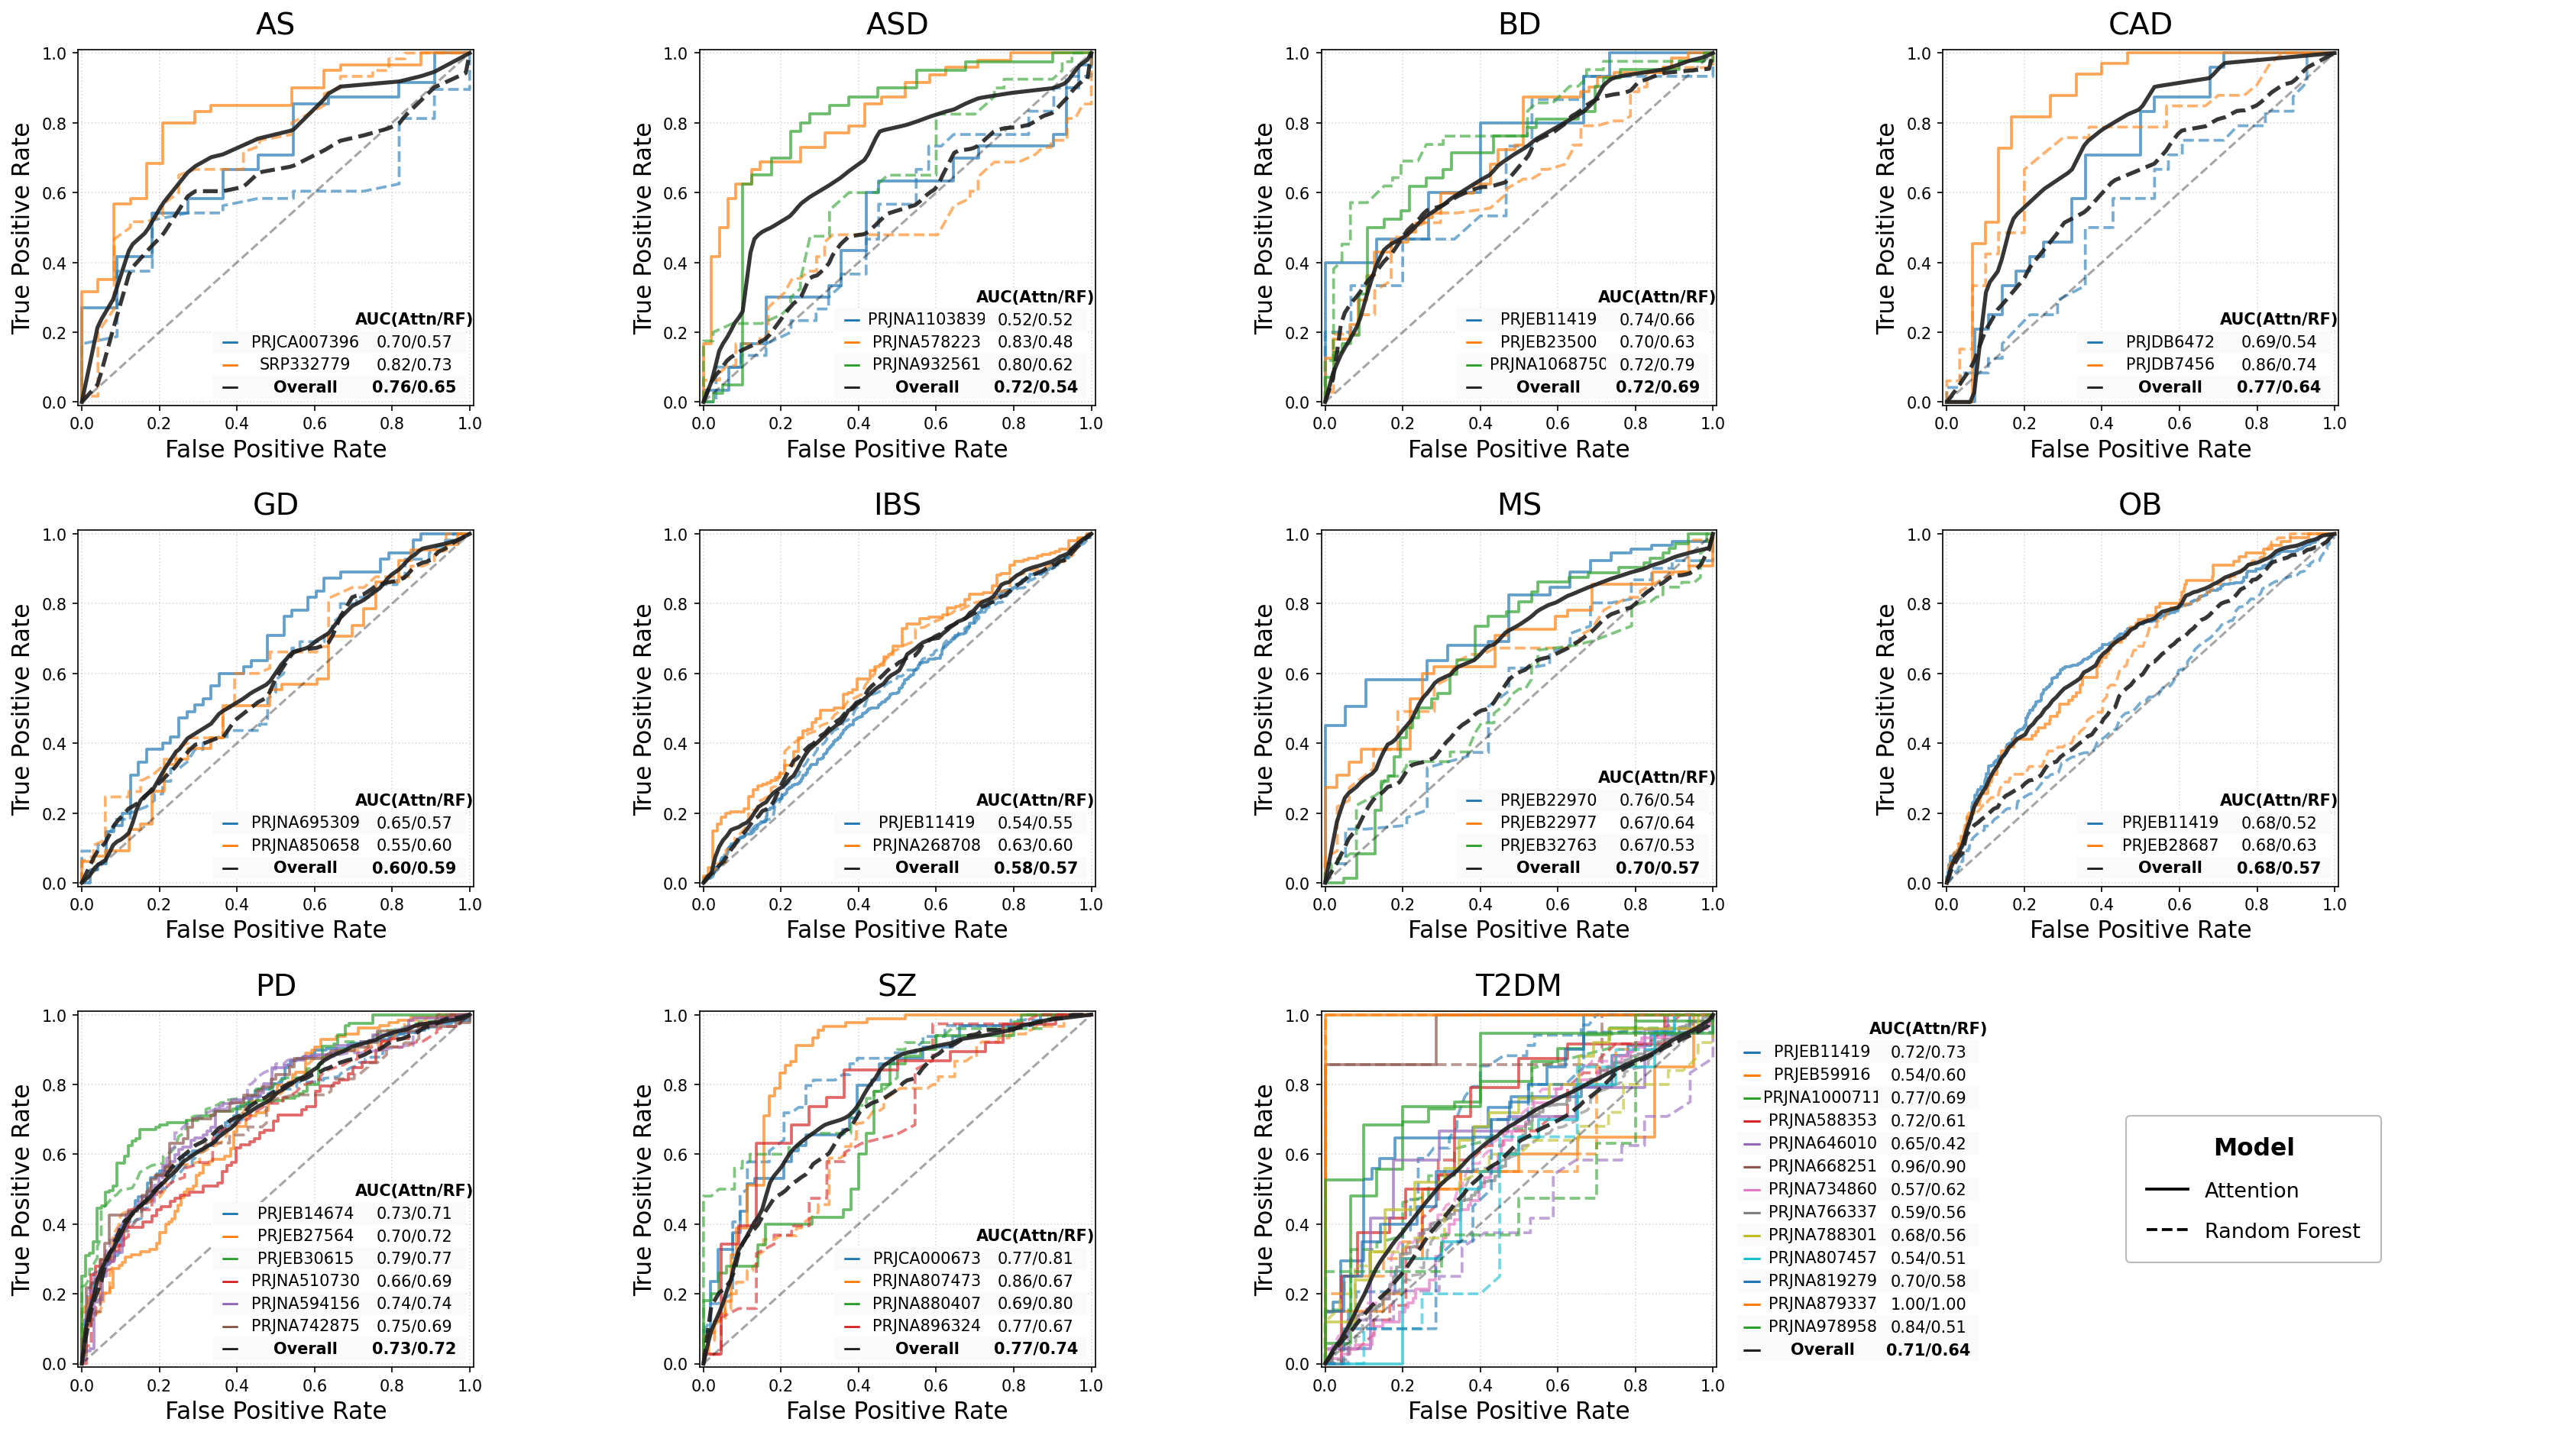

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = "Data/disease_data/all_model_loo.csv"
result_base = "Data/disease_data/" # Ensure this path is accessible

# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    # exit() # In a real scenario, you might exit here

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter out specified diseases ---
# --- 指定要绘制的疾病 (Whitelist) ---
# 在此列表中直接指定您想要绘制的疾病，并按期望的顺序排列
diseases_to_plot_list = ['AS', 'ASD', 'BD', 'CAD',
                         'GD','IBS','MS','OB',
                         'PD','SZ','T2DM'] 

# 筛选出在数据中实际存在的、且在白名单中的疾病
disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in diseases_to_plot_list
}

# 按您在 `diseases_to_plot_list` 中指定的顺序来生成绘图列表
# 这将确保绘图顺序与您的列表顺序一致
if not disease_studies_to_plot:
    print(f"在数据中未找到任何指定的疾病进行绘图。")
    all_disease_names_ordered = []
else:
    all_disease_names_ordered = [
        disease for disease in diseases_to_plot_list 
        if disease in disease_studies_to_plot
    ]
    # 检查是否有指定的疾病在数据文件中未找到
    missing_diseases = set(diseases_to_plot_list) - set(all_disease_names_ordered)
    if missing_diseases:
        print(f"警告：以下在列表中指定的疾病在数据文件 '{data_path}' 中未找到，将被跳过: {', '.join(missing_diseases)}")

num_diseases_total = len(all_disease_names_ordered)
plots_per_row = 4

if num_diseases_total == 0:
    print("没有疾病数据可供绘制，将生成一个空图。")
    num_grid_rows_main = 1
    num_grid_cols_main = 1
else:
    num_grid_rows_main = math.ceil(num_diseases_total / plots_per_row)
    num_grid_cols_main = min(plots_per_row, num_diseases_total)

# Figure size adjustments
# width_per_disease_group defines the width of one entire plot cell in gs_main.
# This cell will be internally divided for ROC + (Table for T2DM or Padding for others).
width_per_disease_group = 7.0 
height_per_row = 5.0 

total_fig_width = num_grid_cols_main * width_per_disease_group
total_fig_height = num_grid_rows_main * height_per_row

fig = plt.figure(figsize=(total_fig_width, total_fig_height), dpi=150)

# --- Main GridSpec ---
gs_main = gridspec.GridSpec(num_grid_rows_main, num_grid_cols_main, figure=fig, 
                            wspace=0.00, # Small gap between disease plot groups
                            hspace=0.33) 

# --- Color configuration ---
def get_tab10_colors(n):
    cmap = plt.cm.get_cmap('tab10')
    if cmap is None: return ['blue'] * n
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

def get_seaborn_distinct_colors(n_colors, palette_type="husl"):
    colors = sns.color_palette(palette_type, n_colors=n_colors)
    return colors

mean_line_color = '#202020'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Iterate through diseases to create plots and tables ---
if num_diseases_total > 0:
    for plot_idx, disease_ab in enumerate(all_disease_names_ordered):
        if disease_ab not in disease_studies_to_plot:
            print(f"警告：在 disease_studies_to_plot 中未找到疾病 {disease_ab} 的研究数据。跳过此疾病。")
            continue
        studies_for_disease = disease_studies_to_plot[disease_ab]

        current_row_main = plot_idx // plots_per_row
        current_col_main = plot_idx % plots_per_row
        
        is_t2dm = (disease_ab == "T2DM")
        
        # Define default internal layout parameters (these match your original global settings)
        default_internal_width_ratios = [2.8, 1.2]
        default_internal_wspace = 0.20  # Original minimal space
        
        # Define T2DM-specific internal layout parameters
        # We will primarily increase the wspace to move the table away from the ROC curve.
        # The width_ratios can also be adjusted if the table itself needs more relative space.

        current_plot_internal_width_ratios = default_internal_width_ratios
        current_plot_internal_wspace = default_internal_wspace

        if is_t2dm:
            t2dm_specific_wspace = 0.20
            t2dm_specific_width_ratios = [2.8, 1.2]
            current_plot_internal_width_ratios = t2dm_specific_width_ratios
            current_plot_internal_wspace = t2dm_specific_wspace
            
        gs_internal_plot_cell = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=gs_main[current_row_main, current_col_main],
            width_ratios=current_plot_internal_width_ratios,
            wspace=current_plot_internal_wspace  # This will now be larger for T2DM
        )
        
        # --- ROC Curve Subplot (Left part of the internal grid) ---
        # All ROC curves are drawn in this subplot, which has a consistent size.
        ax_roc = fig.add_subplot(gs_internal_plot_cell[0, 0]) 
        
        # --- Table Configuration ---
        current_table_target_ax = None
        current_table_loc = ''
        current_table_fontsize = 0
        current_table_col_widths = []
        current_table_scale_y = 1.0

        if is_t2dm:
            # T2DM: Table in the right part of the internal grid
            ax_table_area_for_t2dm = fig.add_subplot(gs_internal_plot_cell[0, 1])
            ax_table_area_for_t2dm.axis('off') 
            
            current_table_target_ax = ax_table_area_for_t2dm
            current_table_loc = 'center' 
            current_table_fontsize = 10 
            current_table_col_widths = [0.18, 0.65, 0.60] # [Symbol, Name, AUCs]
            current_table_scale_y = 1.2
        else:
            # Other diseases: Table inside ax_roc (left part). Right part of internal grid is empty.
            ax_empty_padding_area = fig.add_subplot(gs_internal_plot_cell[0, 1])
            ax_empty_padding_area.axis('off') # Keep this space for layout consistency

            current_table_target_ax = ax_roc # Table will be inside the ROC plot axes
            current_table_loc = 'lower right'
            current_table_fontsize = 10 # Slightly smaller for in-plot table
            current_table_col_widths = [0.09, 0.29, 0.26] # Original for in-plot
            current_table_scale_y = 1.2 # Slightly smaller scale for in-plot


        # --- ROC curve plotting logic (common to all) ---
        sorted_studies = sorted(list(studies_for_disease))
        colors = get_tab10_colors(len(sorted_studies))
        # colors = get_seaborn_distinct_colors(len(sorted_studies), palette_type="husl")
        study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

        all_attn_tpr, all_rf_tpr = [], []
        attn_aucs_for_mean, rf_aucs_for_mean = [], []
        fpr_common = np.linspace(0, 1, 100)
        table_data_for_styling = []

        for study_idx, study in enumerate(sorted_studies):
            study_dir = os.path.join(result_base, disease_ab, study, 'results')
            study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
            current_study_color = study_color_map[study]
            try:
                rf_roc_orig = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
                attn_roc_orig = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
                rf_roc, attn_roc = rf_roc_orig.copy(), attn_roc_orig.copy()
                
                rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
                rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)
                attn_aucs_for_mean.append(attn_auc_val); rf_aucs_for_mean.append(rf_auc_val)
                
                attn_roc_sorted = attn_roc.drop_duplicates(subset=['FPR']).sort_values('FPR')
                rf_roc_sorted = rf_roc.drop_duplicates(subset=['FPR']).sort_values('FPR')
                
                attn_fpr_interp = np.concatenate(([0], attn_roc_sorted['FPR'].values, [1]))
                attn_tpr_interp = np.concatenate(([0], attn_roc_sorted['TPR'].values, [1]))
                rf_fpr_interp = np.concatenate(([0], rf_roc_sorted['FPR'].values, [1]))
                rf_tpr_interp = np.concatenate(([0], rf_roc_sorted['TPR'].values, [1]))
                
                attn_df_interp = pd.DataFrame({'FPR': attn_fpr_interp, 'TPR': attn_tpr_interp}).drop_duplicates(subset=['FPR']).sort_values('FPR')
                rf_df_interp = pd.DataFrame({'FPR': rf_fpr_interp, 'TPR': rf_tpr_interp}).drop_duplicates(subset=['FPR']).sort_values('FPR')

                all_attn_tpr.append(np.interp(fpr_common, attn_df_interp['FPR'], attn_df_interp['TPR']))
                all_rf_tpr.append(np.interp(fpr_common, rf_df_interp['FPR'], rf_df_interp['TPR']))
                
                ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-', linewidth=1.8, alpha=0.7)
                ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--', linewidth=1.8, alpha=0.6)
                table_data_for_styling.append({'color': current_study_color, 'name': study, 'auc_text': f"{attn_auc_rounded:.2f}/{rf_auc_rounded:.2f}", 'is_mean': False, 'row_idx': study_idx})
            except FileNotFoundError:
                print(f"警告：{disease_ab} - {study} 的ROC文件未找到。路径: {study_dir_RF} 或 {study_dir}")
                table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Miss)", 'auc_text': "N/A", 'is_mean': False, 'row_idx': study_idx})
            except Exception as e:
                print(f"处理 {disease_ab} - {study} 时出错：{str(e)}")
                table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Err)", 'auc_text': "Error", 'is_mean': False, 'row_idx': study_idx})

        if attn_aucs_for_mean and rf_aucs_for_mean:
            mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
            mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)
            if all_attn_tpr and all_rf_tpr:
                mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
                mean_attn_tpr[0], mean_attn_tpr[-1] = 0,1; mean_rf_tpr[0], mean_rf_tpr[-1] = 0,1
                ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', linewidth=2.5, alpha=0.9, zorder=10)
                ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', linewidth=2.5, alpha=0.9, zorder=10)
            table_data_for_styling.append({'color': mean_line_color, 'name': "Overall", 'auc_text': f"{mean_attn_auc_rounded:.2f}/{mean_rf_auc_rounded:.2f}", 'is_mean': True, 'row_idx': len(sorted_studies)})

        # --- ROC plot styling (common to all ax_roc) ---
        ax_roc.plot([0,1],[0,1],'k--',alpha=0.35,zorder=5)
        ax_roc.set_xlim([-0.01,1.01]); ax_roc.set_ylim([-0.01,1.01])
        ax_roc.set_aspect(0.9, adjustable='box') # Allow aspect to be controlled by figure/subplot size
        ax_roc.set_title(f"{disease_ab}",fontsize=19,pad=10,)
        ax_roc.set_xlabel('False Positive Rate',fontsize=15)
        ax_roc.set_ylabel('True Positive Rate',fontsize=15, )
        ax_roc.grid(True,linestyle=':',alpha=0.45,zorder=1)
        ax_roc.tick_params(axis='both',which='major',labelsize=10)

        # --- Table plotting logic (uses current_table_target_ax) ---
        if table_data_for_styling and current_table_target_ax:
            cell_text_for_plt_table = [['\u2014', item['name'], item['auc_text']] for item in table_data_for_styling]
            col_labels_for_table = [' ', ' ', 'AUC(Attn/RF)']
            
            the_table = current_table_target_ax.table(cellText=cell_text_for_plt_table, colLabels=col_labels_for_table,
                                                     loc=current_table_loc, colWidths=current_table_col_widths)
            the_table.auto_set_font_size(False)
            the_table.set_fontsize(current_table_fontsize)
            the_table.scale(1, current_table_scale_y)

            for (row, col), cell in the_table.get_celld().items():
                cell.set_linewidth(0); cell.set_edgecolor('none')
                cell.set_text_props(ha='center', va='center')
                if row == 0: 
                    cell.set_facecolor('none'); cell.set_text_props(weight='bold', color='black')
                    if col < 2: cell.get_text().set_text('') 
                else: 
                    current_row_data = table_data_for_styling[row-1]
                    bg_color = row_color_even if current_row_data.get('row_idx', row-1) % 2 == 0 else row_color_odd
                    if current_row_data['is_mean']: bg_color = row_color_even 
                    cell.set_facecolor(bg_color)
                    
                    if col == 0: 
                        cell.get_text().set_color(current_row_data['color'])
                        cell.get_text().set_weight('bold')
                        dash_fontsize_increment = 1
                        # For external T2DM table or internal tables, adjust dash size based on table font size
                        if is_t2dm: # External table for T2DM
                             dash_fontsize_increment = 2
                        else: # Internal table for others
                             dash_fontsize_increment = 1 # Can be smaller if table font is smaller
                        cell.get_text().set_fontsize(current_table_fontsize + dash_fontsize_increment)
                    
                    if current_row_data['is_mean'] and col > 0:
                        cell.set_text_props(weight='bold')
            
            if not is_t2dm: # Table is inside ax_roc for other diseases
                the_table.set_zorder(20) 

# --- GLOBAL LEGEND CREATION ---
legend_elements_global = [
    Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
    Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')
]
legend_placed_in_cell = False
possible_legend_cells = []
for r_idx in range(num_grid_rows_main):
    for c_idx in range(num_grid_cols_main):
        linear_idx = r_idx * num_grid_cols_main + c_idx
        is_cell_used_by_plot = linear_idx < num_diseases_total
        if not is_cell_used_by_plot:
            possible_legend_cells.append((r_idx, c_idx))

if possible_legend_cells:
    legend_cell_r, legend_cell_c = possible_legend_cells[-1] 
    ax_legend_container = fig.add_subplot(gs_main[legend_cell_r, legend_cell_c])
    ax_legend_container.axis('off') 
    the_legend = ax_legend_container.legend(handles=legend_elements_global, loc='center', fontsize=13, 
                               frameon=True, edgecolor='darkgrey', borderpad=1.0, labelspacing=1.0,
                               title='Model', title_fontsize='15')
    the_legend.get_title().set_fontweight('bold')
    legend_placed_in_cell = True

if not legend_placed_in_cell and num_diseases_total > 0: 
    fig.legend(handles=legend_elements_global, loc='lower right', bbox_to_anchor=(0.98, 0.03), 
               ncol=1, fontsize=10, frameon=True, edgecolor='darkgrey',title='Model Type', title_fontsize='11')
elif num_diseases_total == 0:
    print("图中没有绘制任何内容，因此不添加图例。")

# --- Final Layout Adjustment ---
print("提示：fig.tight_layout 使用的 rect=[0, 0.01, 1, 0.46] 参数会严重限制图表的垂直空间。")
print("如果图表垂直方向显得过于压缩，请考虑调整 rect 参数，例如改为 rect=[0, 0.03, 1, 0.95] 或完全移除该参数。")
try:
    fig.tight_layout(pad=0.5) # pad can help, adjust as needed
except ValueError as e:
    print(f"调用 fig.tight_layout 时发生错误: {e}")
    print("尝试不使用 rect 参数进行调整。")
    try:
        fig.tight_layout(pad=1.0) # Increased padding
    except Exception as e_inner:
        print(f"不使用 rect 参数调用 fig.tight_layout 时仍然失败: {e_inner}")


output_filename = "diseases_roc_plot.pdf"
try:
    plt.savefig("Figures/"+output_filename, dpi=300, facecolor='white', bbox_inches='tight')
    print(f"图形已保存为 {output_filename}")
except Exception as e:
    print(f"保存图形时出错：{e}")

plt.show()


成功加载元数据: Data/disease_data/CRC/metadata.tsv


/tmp/ipykernel_190010/2917112141.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_190010/2917112141.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0)


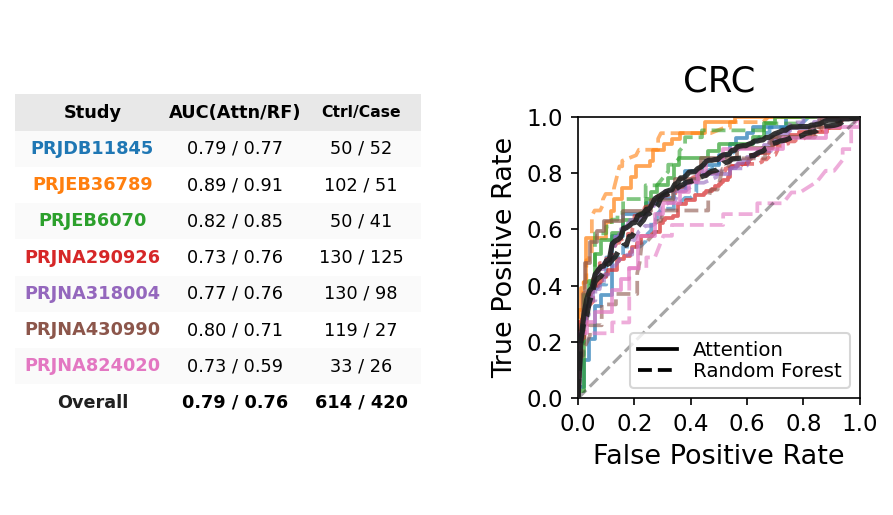

图形 'roc_plot_CRC.png' 已保存。
成功加载元数据: Data/disease_data/IBD/metadata.tsv


/tmp/ipykernel_190010/2917112141.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_190010/2917112141.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0)


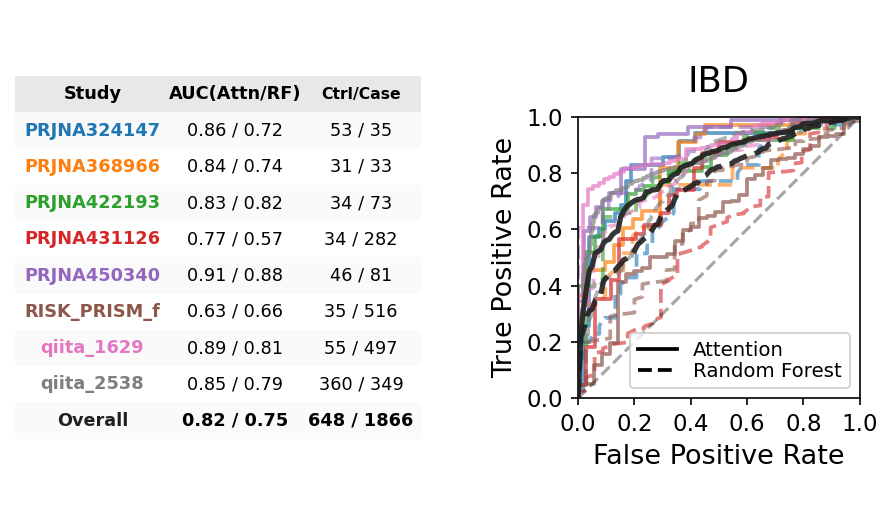

图形 'roc_plot_IBD.png' 已保存。
所有选定疾病的ROC图已单独生成完毕。


In [20]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False

# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = "Data/disease_data/all_model_loo.csv"
result_base = "Data/disease_data/" # Ensure this path is accessible

# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    # exit()

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter for specific diseases and prepare layout ---
target_diseases = ['IBD','CRC']
disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in target_diseases
}

if not disease_studies_to_plot:
    print(f"未找到目标疾病的数据：{', '.join(target_diseases)}")
    # exit()

all_disease_names_to_plot_sorted = sorted(list(disease_studies_to_plot.keys()))

# Define dimensions for each individual plot
single_plot_width = 7 # inches
single_plot_height = 4.2 # inches

# --- Color configuration ---
def get_tab10_colors(n):
    cmap = plt.cm.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

# Parameters for plotting lines
study_line_linewidth = 1.8
study_line_alpha_attn = 0.7
study_line_alpha_rf = 0.6
mean_line_color = '#202020'
mean_line_linewidth = 2.5
mean_line_alpha_attn = 0.9
mean_line_alpha_rf = 0.90
mean_line_zorder = 10

# --- Table Styling Colors ---
header_color = '#E8E8E8'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Iterate through selected diseases to create and save individual plots ---
for disease_ab in all_disease_names_to_plot_sorted:
    studies_for_disease = disease_studies_to_plot[disease_ab]

    # Load metadata for the current disease
    metadata_path = os.path.join(result_base, disease_ab, 'metadata.tsv')
    metadata_df = None
    try:
        metadata_df = pd.read_csv(metadata_path, sep='\t')
        print(f"成功加载元数据: {metadata_path}")
        if 'project' in metadata_df.columns and 'study' not in metadata_df.columns:
            metadata_df.rename(columns={'project': 'study'}, inplace=True)
    except FileNotFoundError:
        print(f"警告：元数据文件未找到于 {metadata_path}。样本数列将不会被填充。")
    except Exception as e:
        print(f"加载元数据时出错 {metadata_path}: {e}")

    # Create a new figure for each disease
    fig_single_disease = plt.figure(figsize=(single_plot_width, single_plot_height), dpi=150)

    gs_single_disease = gridspec.GridSpec(1, 2, figure=fig_single_disease,
                                          wspace=0.6,
                                          width_ratios=[0.55, 0.45])

    ax_table = fig_single_disease.add_subplot(gs_single_disease[0, 0])
    ax_table.axis('off')
    ax_roc = fig_single_disease.add_subplot(gs_single_disease[0, 1])

    sorted_studies = sorted(list(studies_for_disease))
    colors = get_tab10_colors(len(sorted_studies))
    study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

    all_attn_tpr, all_rf_tpr = [], []
    attn_aucs_for_mean, rf_aucs_for_mean = [], []
    fpr_common = np.linspace(0, 1, 100)
    table_data_for_styling = []

    # --- 1. Initialize total sample counters ---
    total_control_count = 0
    total_case_count = 0

    for study_idx, study in enumerate(sorted_studies):
        study_dir = os.path.join(result_base, disease_ab, study, 'results')
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
        current_study_color = study_color_map[study]

        sample_counts_text = "N/A"
        if metadata_df is not None and 'study' in metadata_df.columns and 'group' in metadata_df.columns:
            study_metadata = metadata_df[metadata_df['study'] == study]
            if not study_metadata.empty:
                counts = study_metadata['group'].value_counts()
                control_count = counts.get(0.0, 0)
                case_count = counts.get(1.0, 0)
                sample_counts_text = f"{control_count} / {case_count}"

                # --- 2. Add this study's counts to the totals ---
                total_control_count += control_count
                total_case_count += case_count

        try:
            rf_roc = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
            rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
            rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)

            attn_aucs_for_mean.append(attn_auc_val)
            rf_aucs_for_mean.append(rf_auc_val)
            all_attn_tpr.append(np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR']))
            all_rf_tpr.append(np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR']))

            ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-',
                        linewidth=study_line_linewidth, alpha=study_line_alpha_attn)
            ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--',
                        linewidth=study_line_linewidth, alpha=study_line_alpha_rf)

            table_data_for_styling.append({'color': current_study_color, 'name': study,
                                           'auc_text': f"{attn_auc_rounded:.2f} / {rf_auc_rounded:.2f}",
                                           'sample_counts': sample_counts_text,
                                           'is_mean': False, 'row_idx': study_idx})
        except FileNotFoundError:
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Missing)",
                                           'auc_text': "N/A", 'sample_counts': sample_counts_text,
                                           'is_mean': False, 'row_idx': study_idx})
        except Exception as e:
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Error)",
                                           'auc_text': "Error", 'sample_counts': "N/A",
                                           'is_mean': False, 'row_idx': study_idx})

    if attn_aucs_for_mean and rf_aucs_for_mean:
        mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
        mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)
        if all_attn_tpr and all_rf_tpr:
            mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
            mean_attn_tpr[0], mean_attn_tpr[-1] = 0, 1
            mean_rf_tpr[0], mean_rf_tpr[-1] = 0, 1
            ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', linewidth=mean_line_linewidth, alpha=mean_line_alpha_attn, zorder=mean_line_zorder)
            ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', linewidth=mean_line_linewidth, alpha=mean_line_alpha_rf, zorder=mean_line_zorder)

        # --- 3. Use the total counts for the "Mean" row ---
        total_counts_text = f"{total_control_count} / {total_case_count}"
        table_data_for_styling.append({'color': mean_line_color, 'name': "Overall",
                                       'auc_text': f"{mean_attn_auc_rounded:.2f} / {mean_rf_auc_rounded:.2f}",
                                       'sample_counts': total_counts_text, 'is_mean': True, 'row_idx': len(sorted_studies)})

    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.35)
    ax_roc.set_xlim([0, 1])
    ax_roc.set_ylim([0, 1])
    tick_positions = np.arange(0, 1.01, 0.2)
    ax_roc.set_xticks(tick_positions)
    ax_roc.set_yticks(tick_positions)
    ax_roc.set_aspect('equal', adjustable='box')
    if disease_ab=="IBD_feces" : disease_ab = 'IBD'
    ax_roc.set_title(f"{disease_ab}", fontsize=17, pad=12,)
    ax_roc.set_xlabel('False Positive Rate', fontsize=13, )
    ax_roc.set_ylabel('True Positive Rate', fontsize=13, )
    ax_roc.tick_params(axis='both', which='major', labelsize=11)

    legend_elements = [Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
                       Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')]
    ax_roc.legend(handles=legend_elements, loc='lower right', fontsize=9.5, labelspacing=0.1)

    if table_data_for_styling:
        cell_text_for_plt_table = []
        col_labels = ['Study', 'AUC(Attn/RF)', 'Ctrl/Case']
        for item in table_data_for_styling:
            cell_text_for_plt_table.append([item['name'], item['auc_text'], item['sample_counts']])

        the_table = ax_table.table(cellText=cell_text_for_plt_table, colLabels=col_labels, loc='center',
                                     colWidths=[0.45, 0.38, 0.35])

        the_table.auto_set_font_size(False)
        the_table.set_fontsize(8.5)
        the_table.scale(1, 1.45)

        for (row, col), cell in the_table.get_celld().items():
            cell.set_linewidth(0)
            cell.set_text_props(ha='center', va='center')
            if row == 0:
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='black')
                if col == 2: cell.set_fontsize(7.5)
            else:
                current_row_data = table_data_for_styling[row-1]
                if current_row_data['row_idx'] % 2 == 0: cell.set_facecolor(row_color_even)
                else: cell.set_facecolor(row_color_odd)
                if col == 0:
                    cell.get_text().set_color(current_row_data['color'])
                    cell.get_text().set_weight('bold')
                if current_row_data['is_mean']:
                    cell.get_text().set_weight('bold')

    fig_single_disease.tight_layout(pad=1.0)
    # Use display() if in a Jupyter Notebook
    # from IPython.display import display
    display(fig_single_disease)
    
    output_filename_single = f"roc_plot_{disease_ab}.png"

    try:
        plt.savefig("Figures/" + output_filename_single, bbox_inches='tight', dpi=300, facecolor='white')
        print(f"图形 '{output_filename_single}' 已保存。")
    except Exception as e:
        print(f"保存图形 '{output_filename_single}' 时出错：{e}")

    plt.close(fig_single_disease)

print("所有选定疾病的ROC图已单独生成完毕。")


成功加载元数据: Data/disease_data/CRC/metadata.tsv


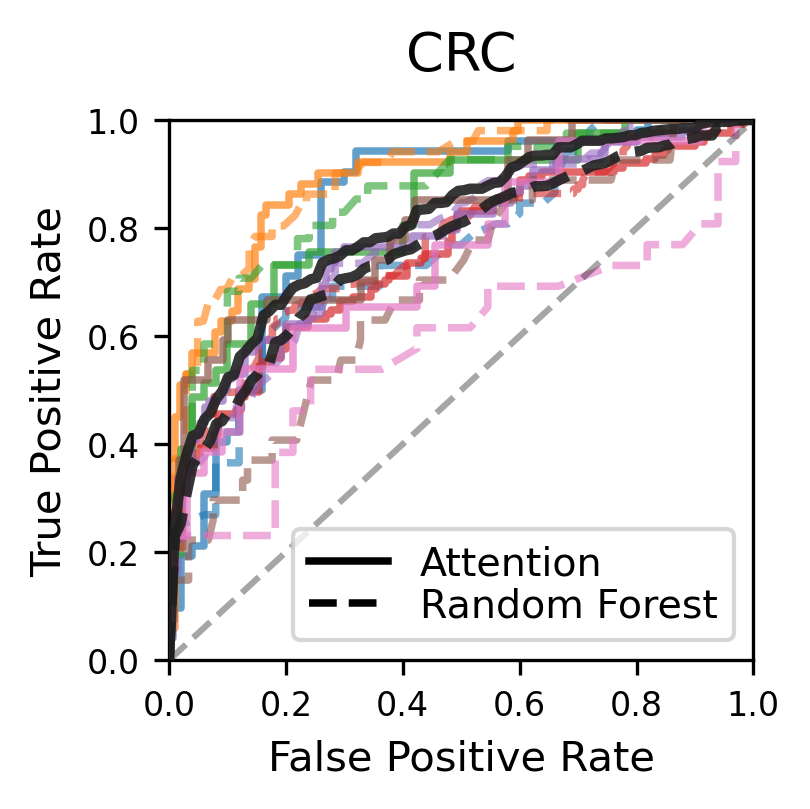

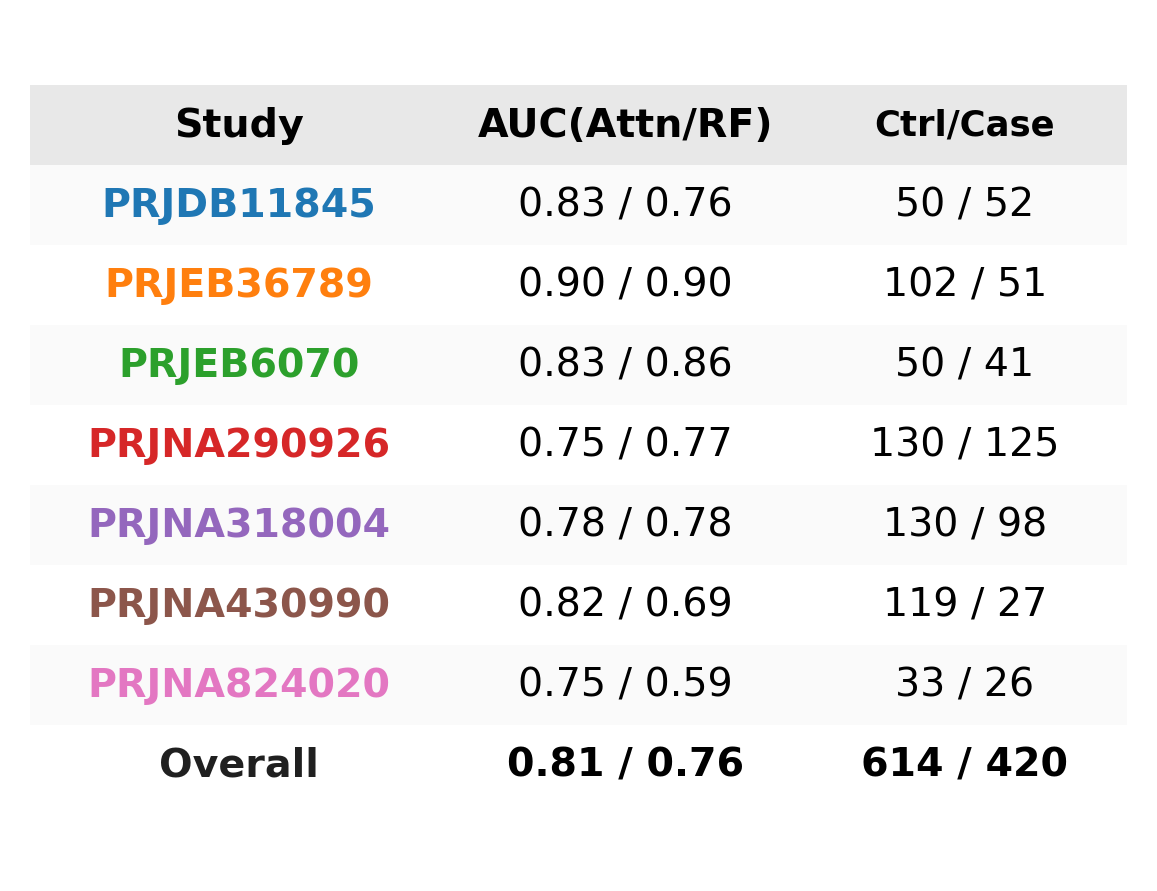

图形 'roc_plot_CRC.pdf' 已保存。
图例 'roc_table_CRC.pdf' 已保存。
成功加载元数据: Data/disease_data/IBD/metadata.tsv


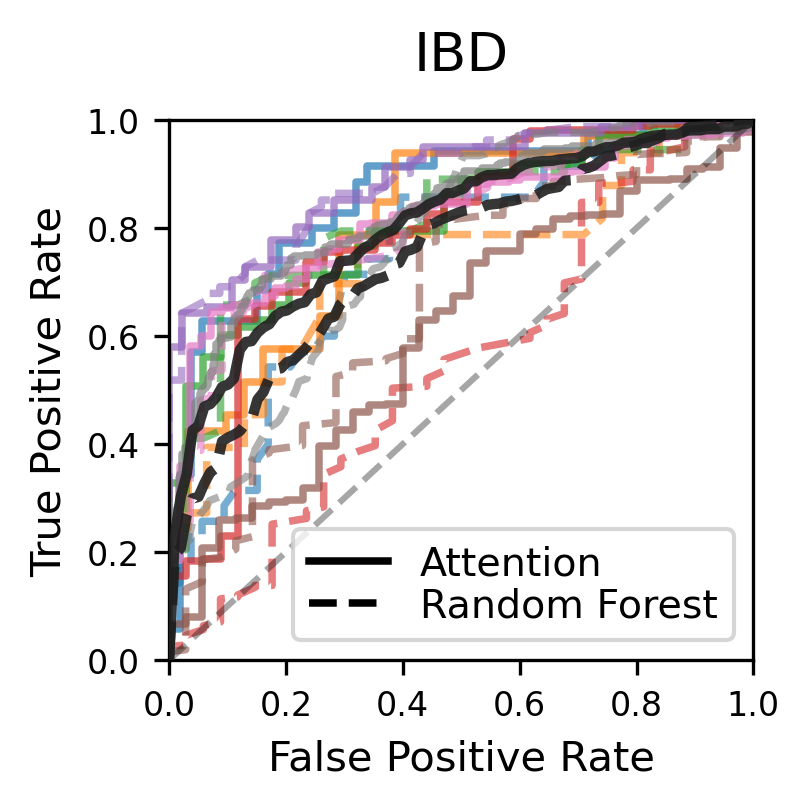

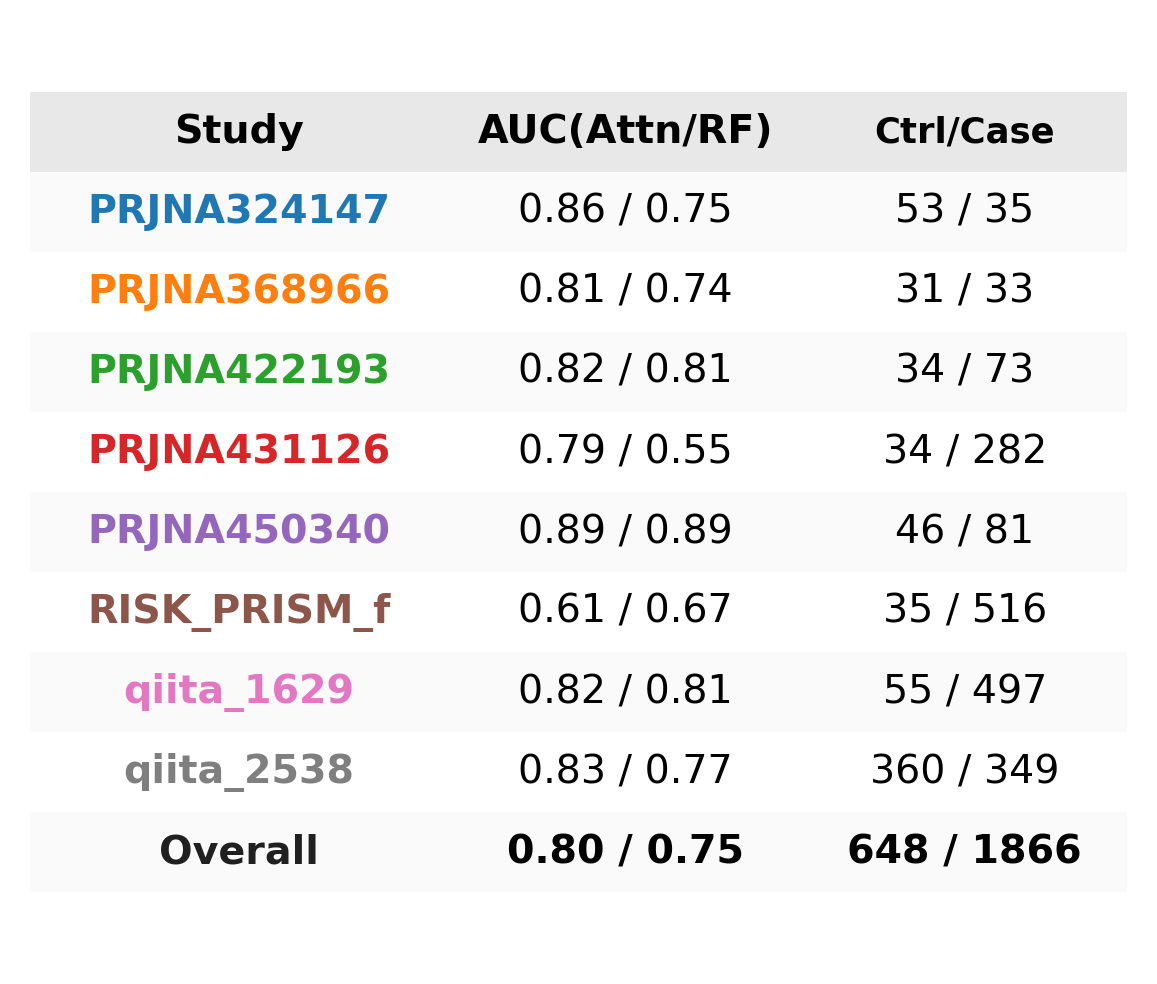

图形 'roc_plot_IBD.pdf' 已保存。
图例 'roc_table_IBD.pdf' 已保存。
所有选定疾病的ROC图和图例已作为独立的PDF文件生成完毕。


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = "Data/disease_data/all_model_loo.csv"
result_base = "Data/disease_data/" # Ensure this path is accessible
output_dir = "Figures/" # Define output directory for figures

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    # In a real script, you might exit here. For this example, we create a dummy df.
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])


disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter for specific diseases and prepare layout ---
target_diseases = ['IBD','CRC']
disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in target_diseases
}

if not disease_studies_to_plot:
    print(f"未找到目标疾病的数据：{', '.join(target_diseases)}")
    # exit()

all_disease_names_to_plot_sorted = sorted(list(disease_studies_to_plot.keys()))

# --- Color configuration ---
def get_tab10_colors(n):
    cmap = plt.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

# Parameters for plotting lines
study_line_linewidth = 1.8
study_line_alpha_attn = 0.7
study_line_alpha_rf = 0.6
mean_line_color = '#202020'
mean_line_linewidth = 2.5
mean_line_alpha_attn = 0.9
mean_line_alpha_rf = 0.90
mean_line_zorder = 10

# --- Table Styling Colors ---
header_color = '#E8E8E8'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Iterate through selected diseases to create and save individual plots ---
for disease_ab in all_disease_names_to_plot_sorted:
    studies_for_disease = disease_studies_to_plot.get(disease_ab, [])

    # Load metadata for the current disease
    metadata_path = os.path.join(result_base, disease_ab, 'metadata.tsv')
    metadata_df = None
    try:
        metadata_df = pd.read_csv(metadata_path, sep='\t')
        print(f"成功加载元数据: {metadata_path}")
        if 'project' in metadata_df.columns and 'study' not in metadata_df.columns:
            metadata_df.rename(columns={'project': 'study'}, inplace=True)
    except FileNotFoundError:
        print(f"警告：元数据文件未找到于 {metadata_path}。样本数列将不会被填充。")
    except Exception as e:
        print(f"加载元数据时出错 {metadata_path}: {e}")

    # --- ### MODIFICATION ### Create two separate figures, one for the ROC plot and one for the table. ---
    # Figure 1: ROC Plot
    fig_roc, ax_roc = plt.subplots(figsize=(2.8, 2.8), dpi=300) # Adjusted size for a single plot

    # Figure 2: Table
    # The figure size for the table is an estimate; bbox_inches='tight' during save will crop it.
    num_rows = len(studies_for_disease) + 2 # Studies + Mean + Header
    table_height = num_rows * 0.4
    fig_table, ax_table = plt.subplots(figsize=(4, table_height), dpi=300)
    ax_table.axis('off')

    sorted_studies = sorted(list(studies_for_disease))
    colors = get_tab10_colors(len(sorted_studies))
    study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

    all_attn_tpr, all_rf_tpr = [], []
    attn_aucs_for_mean, rf_aucs_for_mean = [], []
    fpr_common = np.linspace(0, 1, 100)
    table_data_for_styling = []

    total_control_count = 0
    total_case_count = 0

    for study_idx, study in enumerate(sorted_studies):
        study_dir = os.path.join(result_base, disease_ab, study, 'results')
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
        current_study_color = study_color_map[study]

        sample_counts_text = "N/A"
        if metadata_df is not None and 'study' in metadata_df.columns and 'group' in metadata_df.columns:
            study_metadata = metadata_df[metadata_df['study'] == study]
            if not study_metadata.empty:
                counts = study_metadata['group'].value_counts()
                control_count = counts.get(0.0, 0)
                case_count = counts.get(1.0, 0)
                sample_counts_text = f"{control_count} / {case_count}"
                total_control_count += control_count
                total_case_count += case_count

        try:
            rf_roc = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
            rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
            rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)

            attn_aucs_for_mean.append(attn_auc_val)
            rf_aucs_for_mean.append(rf_auc_val)
            all_attn_tpr.append(np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR']))
            all_rf_tpr.append(np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR']))

            # Plotting on ax_roc
            ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-',
                        linewidth=study_line_linewidth, alpha=study_line_alpha_attn)
            ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--',
                        linewidth=study_line_linewidth, alpha=study_line_alpha_rf)

            table_data_for_styling.append({'color': current_study_color, 'name': study,
                                           'auc_text': f"{attn_auc_rounded:.2f} / {rf_auc_rounded:.2f}",
                                           'sample_counts': sample_counts_text,
                                           'is_mean': False, 'row_idx': study_idx})
        except FileNotFoundError:
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Missing)",
                                           'auc_text': "N/A", 'sample_counts': sample_counts_text,
                                           'is_mean': False, 'row_idx': study_idx})
        except Exception as e:
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Error)",
                                           'auc_text': "Error", 'sample_counts': "N/A",
                                           'is_mean': False, 'row_idx': study_idx})

    if attn_aucs_for_mean and rf_aucs_for_mean:
        mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
        mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)
        if all_attn_tpr and all_rf_tpr:
            mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
            mean_attn_tpr[0], mean_attn_tpr[-1] = 0, 1
            mean_rf_tpr[0], mean_rf_tpr[-1] = 0, 1
            # Plotting mean lines on ax_roc
            ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', linewidth=mean_line_linewidth, alpha=mean_line_alpha_attn, zorder=mean_line_zorder)
            ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', linewidth=mean_line_linewidth, alpha=mean_line_alpha_rf, zorder=mean_line_zorder)

        total_counts_text = f"{total_control_count} / {total_case_count}"
        table_data_for_styling.append({'color': mean_line_color, 'name': "Overall",
                                       'auc_text': f"{mean_attn_auc_rounded:.2f} / {mean_rf_auc_rounded:.2f}",
                                       'sample_counts': total_counts_text, 'is_mean': True, 'row_idx': len(sorted_studies)})

    # --- Configure ROC plot (ax_roc) ---
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.35)
    ax_roc.set_xlim([0, 1])
    ax_roc.set_ylim([0, 1])
    tick_positions = np.arange(0, 1.01, 0.2)
    ax_roc.set_xticks(tick_positions)
    ax_roc.set_yticks(tick_positions)

    # ax_roc.set_aspect('equal', adjustable='box')
    ax_roc.set_title(f"{disease_ab}", fontsize=13, pad=12)
    ax_roc.set_xlabel('False Positive Rate', fontsize=10)
    ax_roc.set_ylabel('True Positive Rate', fontsize=10)
    ax_roc.tick_params(axis='both', which='major', labelsize=8)
    
    legend_elements = [Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
                       Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')]
    ax_roc.legend(handles=legend_elements, loc='lower right', fontsize=9.5, labelspacing=0.1)
    fig_roc.tight_layout()

    # --- Configure Table plot (ax_table) ---
    if table_data_for_styling:
        cell_text_for_plt_table = []
        col_labels = ['Study', 'AUC(Attn/RF)', 'Ctrl/Case']
        for item in table_data_for_styling:
            cell_text_for_plt_table.append([item['name'], item['auc_text'], item['sample_counts']])

        the_table = ax_table.table(cellText=cell_text_for_plt_table, colLabels=col_labels, loc='center',
                                     colWidths=[0.45, 0.38, 0.35])

        the_table.auto_set_font_size(False)
        the_table.set_fontsize(9.5)
        the_table.scale(1, 1.6)

        for (row, col), cell in the_table.get_celld().items():
            cell.set_linewidth(0)
            cell.set_text_props(ha='center', va='center')
            if row == 0:
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='black')
                if col == 2: cell.set_fontsize(8.5)
            else:
                current_row_data = table_data_for_styling[row-1]
                if current_row_data['row_idx'] % 2 == 0: cell.set_facecolor(row_color_even)
                else: cell.set_facecolor(row_color_odd)
                if col == 0:
                    cell.get_text().set_color(current_row_data['color'])
                    cell.get_text().set_weight('bold')
                if current_row_data['is_mean']:
                    cell.get_text().set_weight('bold')
    
    # --- ### MODIFICATION ### Save each figure to a separate PDF file. ---
    roc_output_filename = f"roc_plot_{disease_ab}.pdf"
    table_output_filename = f"roc_table_{disease_ab}.pdf"
    display(fig_roc)
    display(fig_table)
    try:
        # Save the ROC curve plot
        fig_roc.savefig(os.path.join(output_dir, roc_output_filename), format='pdf', bbox_inches='tight', facecolor='white')
        print(f"图形 '{roc_output_filename}' 已保存。")
        
        # Save the table
        fig_table.savefig(os.path.join(output_dir, table_output_filename), format='pdf', bbox_inches='tight', facecolor='white')
        print(f"图例 '{table_output_filename}' 已保存。")
        
    except Exception as e:
        print(f"保存图形时出错: {e}")
    

    # --- ### MODIFICATION ### Close both figures to free memory. ---
    plt.close(fig_roc)
    plt.close(fig_table)

print("所有选定疾病的ROC图和图例已作为独立的PDF文件生成完毕。")

# 所有疾病把的结果拼接起来的

平均随机森林AUC (AUC ROC): 0.562
平均Attention模型AUC (auc): 0.651


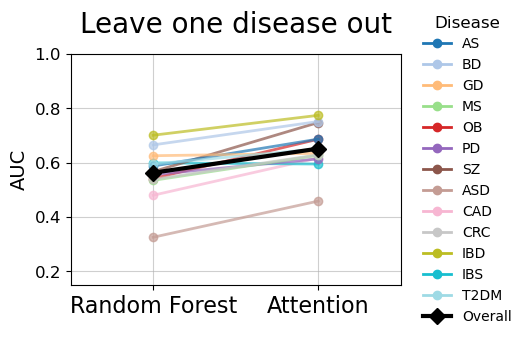

图表已保存为 Figures/auc_comparison_by_disease.png


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# 1. 定义新数据文件的路径
csv_path = "Data/loo_all_diseases/all_model_loo.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"错误: 文件 '{csv_path}' 未找到。请检查文件路径。")
    exit()

# 2. 确保所需的列存在 (MODIFIED: 'disease' is the key column now)
required_columns = ['disease', 'auc', 'AUC ROC']
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"错误: CSV文件缺少以下必需列: {', '.join(missing_cols)}")
    exit()

# 3. 数据处理和准备
# 处理潜在的重复列
df = df.loc[:,~df.columns.duplicated()].copy() 
# 处理 'disease' 列中潜在的NaN值并确保其为字符串类型
df['disease'] = df['disease'].fillna('Unknown').astype(str)

# 根据长度和字母顺序对唯一疾病名称进行排序
sorted_unique_diseases = sorted(
    list(df['disease'].unique()),
    key=lambda x: (len(x), x)
)

# 4. 分配颜色
# 使用排序后的唯一疾病列表分配颜色
base_colors = list(mcolors.TABLEAU_COLORS.values())
if len(sorted_unique_diseases) > len(base_colors):
    cmap = plt.get_cmap('tab20', len(sorted_unique_diseases))
    colors_to_use = [cmap(i) for i in range(len(sorted_unique_diseases))]
else:
    colors_to_use = base_colors
color_map = {disease: colors_to_use[i % len(colors_to_use)] for i, disease in enumerate(sorted_unique_diseases)}

# 5. 创建图表
fig, ax = plt.subplots(figsize=(6, 3))
fig.subplots_adjust(right=0.70, left=0.15)

# 统一的可视化参数（与您的风格保持一致）
model_positions = [0, 1]
xlim_range = (-0.5, 1.5)
marker_style = 'o'      # 单个疾病连线的标记
marker_size = 6         # 标记的大小
line_linewidth = 2
mean_line_linewidth = 3
mean_marker_size = 8

# 6. 为每个疾病绘制连线 (MODIFIED: Iterating over diseases directly)
for _, row_data in df.iterrows():
    # .get()方法可以安全地获取颜色，如果疾病名称不存在则返回灰色
    disease_color = color_map.get(row_data['disease'], 'gray')
    ax.plot(
        model_positions,
        [row_data['AUC ROC'], row_data['auc']], # 随机森林AUC, Attention AUC
        color=disease_color,
        alpha=0.7,
        marker=marker_style,
        markersize=marker_size,
        linewidth=line_linewidth,
        linestyle='-'
    )

# 7. 计算并绘制平均线
mean_rf_auc = df['AUC ROC'].mean()
mean_attention_auc = df['auc'].mean()
print(f"平均随机森林AUC (AUC ROC): {mean_rf_auc:.3f}")
print(f"平均Attention模型AUC (auc): {mean_attention_auc:.3f}")

mean_line_plot = ax.plot(
    model_positions,
    [mean_rf_auc, mean_attention_auc],
    color='black',
    linestyle='-',
    linewidth=mean_line_linewidth,
    marker='D',
    markersize=mean_marker_size,
    label='Overall',
    zorder=100
)[0]

# 8. 设置图表美学
ax.grid(True, linestyle='-', alpha=0.6)
ax.set_xlim(xlim_range)
ax.set_ylim(0.15, 1.0)
# MODIFIED: 更新标题以反映新的实验
ax.set_title('Leave one disease out', fontsize=20, pad=15, ) 
ax.set_xticks(model_positions)
ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=16)
ax.set_ylabel('AUC', fontsize=14)
for label in ax.get_yticklabels():
    label.set_fontsize(12)

# 9. 创建并添加图例
legend_handles = []
# 按排序顺序为每种疾病添加图例条目
for disease in sorted_unique_diseases:
    legend_handles.append(Line2D([0], [0],
                                 color=color_map[disease],
                                 lw=line_linewidth,
                                 label=disease, # 标签现在是疾病名称
                                 marker=marker_style,
                                 markersize=marker_size,
                                 linestyle='-'))

# 添加平均线的图例条目
legend_handles.append(mean_line_plot)

# 图例参数
legend_params = {
    'bbox_to_anchor': (1.03, 0.5),
    'loc': 'center left',
    'ncol': 1,
    'fontsize': 10,
    'title': 'Disease',
    'title_fontsize': 12,
    'frameon': False
}
ax.legend(handles=legend_handles, **legend_params)

# 10. 保存并显示图表
# MODIFIED: 使用新的文件名
output_filename = 'Figures/auc_comparison_by_disease.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"图表已保存为 {output_filename}")

Mean AUC ROC: 0.638
Mean Attention AUC: 0.702


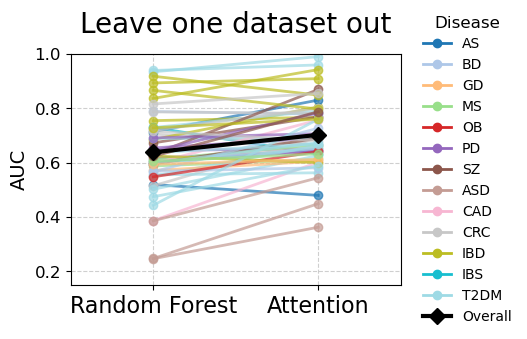

Plot saved as auc_comparison_single_plot_legend_markers_news.png


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Define the path to your CSV file
# Make sure this path is correct or the file is in the same directory as the script.
csv_path = "/home/cjj/projects/memebed_analysis/script/script_leave_one_out_only_one/all_data_study_new/merged_results_with_disease_ab.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: The file '{csv_path}' was not found. Please check the file path.")
    exit()

# Ensure required columns exist
required_columns = ['study', 'auc', 'AUC ROC', 'disease_name_ab']
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"Error: The CSV file is missing the following required columns: {', '.join(missing_cols)}")
    exit()

# Data processing and preparation
df = df.loc[:,~df.columns.duplicated()].copy() # Handle potential duplicate columns
df['disease_name_ab'] = df['disease_name_ab'].replace('IBD_feces', 'IBD')
# Handle potential NaN values in 'disease_name_ab' and ensure it's string type
df['disease_name_ab'] = df['disease_name_ab'].fillna('Unknown').astype(str)

# Get unique disease names and sort them based on length then alphabetically
sorted_unique_diseases = sorted(
    list(df['disease_name_ab'].unique()),
    key=lambda x: (len(x), x)
)

# Assign colors using the sorted list of unique diseases
base_colors = list(mcolors.TABLEAU_COLORS.values())
if len(sorted_unique_diseases) > len(base_colors):
    cmap = plt.get_cmap('tab20', len(sorted_unique_diseases))
    colors_to_use = [cmap(i) for i in range(len(sorted_unique_diseases))]
else:
    colors_to_use = base_colors
color_map = {disease: colors_to_use[i % len(colors_to_use)] for i, disease in enumerate(sorted_unique_diseases)}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 3))
fig.subplots_adjust(right=0.70, left=0.15)

# Unified visualization parameters from your style
model_positions = [0, 1]
xlim_range = (-0.5, 1.5)
marker_style = 'o' # This is the marker for individual study lines
marker_size = 6    # This is its size
line_linewidth = 2
mean_line_linewidth = 3
mean_marker_size = 8

# 1. Plot lines for each study, colored by disease_name_ab
for _, row_data in df.iterrows():
    disease_color = color_map.get(row_data['disease_name_ab'], 'gray')
    ax.plot(
        model_positions,
        [row_data['AUC ROC'], row_data['auc']],
        color=disease_color,
        alpha=0.7,
        marker=marker_style, # Applies marker to actual plot lines
        markersize=marker_size, # Applies marker size
        linewidth=line_linewidth,
        linestyle='-' # Solid line for these
    )

# 2. Calculate and plot the mean line
mean_rf_auc = df['AUC ROC'].mean()
mean_attention_auc = df['auc'].mean()
print(f"Mean AUC ROC: {mean_rf_auc:.3f}")
print(f"Mean Attention AUC: {mean_attention_auc:.3f}")
mean_line_plot = ax.plot(
    model_positions,
    [mean_rf_auc, mean_attention_auc],
    color='black',
    linestyle='-',
    linewidth=mean_line_linewidth,
    marker='D',
    markersize=mean_marker_size,
    label='Overall',
    zorder=100
)[0]

# 3. Set plot aesthetics
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(xlim_range)
ax.set_ylim(0.15, 1.0)
ax.set_title('Leave one dataset out', fontsize=20, pad=15, )
ax.set_xticks(model_positions)
ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=16, )
ax.set_ylabel('AUC', fontsize=14, )
for label in ax.get_yticklabels():
    label.set_fontsize(12)

# 4. Create and add the legend using the sorted_unique_diseases list
legend_handles = []
# ***** MODIFICATION START *****
# Add disease color representations to legend in the sorted order
# Ensure these legend handles include the marker style
for disease in sorted_unique_diseases:
    legend_handles.append(Line2D([0], [0], # Dummy data points for the line
                                 color=color_map[disease],
                                 lw=line_linewidth, # Match actual line width
                                 label= disease,
                                 marker=marker_style, # Add marker style
                                 markersize=marker_size, # Add marker size
                                 linestyle='-')) # Explicitly set linestyle if needed
# ***** MODIFICATION END *****

# Add the mean line to legend handles (already includes its style from the plot object)
legend_handles.append(mean_line_plot)

legend_params = {
    'bbox_to_anchor': (1.03, 0.5),
    'loc': 'center left',
    'ncol': 1,
    'fontsize': 10,
    'title': 'Disease',
    'title_fontsize': 12,
    'frameon': False
}
ax.legend(handles=legend_handles, **legend_params)

# Save and show the plot
# Changed output filename to reflect the fix
output_filename = 'auc_comparison_single_plot_legend_markers_news.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved as {output_filename}")

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import os
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
def plot_graph_and_get_handles(ax, df, title, disease_col_name):
    """
    Plots the comparison graph on the given axes and returns the handles for the legend.
    
    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        df (pd.DataFrame): The dataframe containing the data.
        title (str): The title for the plot.
        disease_col_name (str): The name of the column containing disease/study labels.

    Returns:
        list: A list of legend handles for creating a legend later.
    """
    # --- Data Preparation ---
    # Sort unique diseases for consistent color mapping and legend order
    sorted_unique_diseases = sorted(
        list(df[disease_col_name].unique()),
        key=lambda x: (len(x), x)
    )

    # Assign colors
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    if len(sorted_unique_diseases) > len(base_colors):
        cmap = plt.get_cmap('tab20', len(sorted_unique_diseases))
        colors_to_use = [cmap(i) for i in range(len(sorted_unique_diseases))]
    else:
        colors_to_use = base_colors
    color_map = {disease: colors_to_use[i % len(colors_to_use)] for i, disease in enumerate(sorted_unique_diseases)}

    # --- Plotting Parameters ---
    model_positions = [0, 1]
    marker_style = 'o'
    marker_size = 6
    line_linewidth = 2
    mean_line_linewidth = 3
    mean_marker_size = 8

    # --- Plotting Individual Lines ---
    for _, row_data in df.iterrows():
        disease_color = color_map.get(row_data[disease_col_name], 'gray')
        ax.plot(
            model_positions,
            [row_data['AUC ROC'], row_data['auc']],
            color=disease_color,
            alpha=0.7,
            marker=marker_style,
            markersize=marker_size,
            linewidth=line_linewidth,
            linestyle='-'
        )

    # --- Plotting Mean Line ---
    mean_rf_auc = df['AUC ROC'].mean()
    mean_attention_auc = df['auc'].mean()
    mean_line_plot = ax.plot(
        model_positions,
        [mean_rf_auc, mean_attention_auc],
        color='black',
        linestyle='-',
        linewidth=mean_line_linewidth,
        marker='D',
        markersize=mean_marker_size,
        label='Overall', # This label is used for the legend handle
        zorder=100
    )[0]

    # --- Setting Plot Aesthetics ---
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0.15, 1.0)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xticks(model_positions)
    ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=16)
    ax.set_ylabel('AUC', fontsize=14)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        
    # --- Generating Legend Handles ---
    legend_handles = []
    # Add disease color representations to legend
    for disease in sorted_unique_diseases:
        legend_handles.append(Line2D([0], [0],
                                     color=color_map[disease],
                                     lw=line_linewidth,
                                     label=disease,
                                     marker=marker_style,
                                     markersize=marker_size,
                                     linestyle='-'))
    # Add the 'Overall' mean line to the handles
    legend_handles.append(mean_line_plot)
    
    return legend_handles

# ==============================================================================
# MAIN SCRIPT EXECUTION
# ==============================================================================

# --- 1. Process and Plot "Leave one study out" ---

# Define path to the first CSV file
csv_path_study = "/home/cjj/projects/memebed_analysis/script/script_leave_one_out_only_one/all_data_study_new/merged_results_with_disease_ab.csv"
output_plot_study = 'Figures/auc_plot_leave_one_study_out.png'

try:
    df_study = pd.read_csv(csv_path_study)
    df_study = df_study.loc[:,~df_study.columns.duplicated()].copy()
    df_study['disease_name_ab'] = df_study['disease_name_ab'].replace('IBD_feces', 'IBD').fillna('Unknown').astype(str)
    
    # Create figure and plot the graph
    fig1, ax1 = plt.subplots(figsize=(4, 3.))
    fig1.subplots_adjust(left=0.15, right=0.95) # Adjust spacing as there's no legend
    
    # Plot the graph and get the legend handles
    # We will use these handles for the final, separate legend file
    legend_handles_for_saving = plot_graph_and_get_handles(ax1, df_study, 'Leave one dataset out', 'disease_name_ab')

    # Save the plot-only figure
    plt.savefig(output_plot_study, dpi=300, bbox_inches='tight')
    plt.close(fig1) # Close the figure to free up memory
    print(f"✅ Plot 1 saved as '{output_plot_study}'")

except FileNotFoundError:
    print(f"❌ Error: The file '{csv_path_study}' was not found.")


# --- 2. Process and Plot "Leave one disease out" ---

# Define path to the second CSV file
csv_path_disease = "Data/loo_all_diseases/all_model_loo.csv"
output_plot_disease = 'Figures/auc_plot_leave_one_disease_out.png'

try:
    df_disease = pd.read_csv(csv_path_disease)
    df_disease = df_disease.loc[:,~df_disease.columns.duplicated()].copy()
    df_disease['disease'] = df_disease['disease'].fillna('Unknown').astype(str)
    
    # Create figure and plot the graph
    fig2, ax2 = plt.subplots(figsize=(4, 3.))
    fig2.subplots_adjust(left=0.15, right=0.95) # Adjust spacing
    
    # Plot the graph. We don't need to save the handles again.
    _ = plot_graph_and_get_handles(ax2, df_disease, 'Leave one disease out', 'disease')

    # Save the plot-only figure
    plt.savefig(output_plot_disease, dpi=300, bbox_inches='tight')
    plt.close(fig2)
    print(f"✅ Plot 2 saved as '{output_plot_disease}'")

except FileNotFoundError:
    print(f"❌ Error: The file '{csv_path_disease}' was not found.")


# --- 3. Create and Save the Standalone Legend ---
output_legend = 'Figures/comparison_legend.pdf'

# Check if legend handles were created successfully before proceeding
if 'legend_handles_for_saving' in locals():
    # Create a new figure specifically for the legend
    # The size is chosen to be wide and short to accommodate 3 columns
    fig_legend, ax_legend = plt.subplots(figsize=(3, 2.5))

    # Create the legend on the new axes
    ax_legend.legend(
        handles=legend_handles_for_saving,
        ncol=2,               # Arrange legend in 3 columns as requested
        loc='center',         # Center the legend in the figure
        frameon=False,        # No frame around the legend
        title='Disease',
        title_fontsize=15,
        fontsize=10,
        # title_fontproperties={'size': 15, 'horizontalalignment': 'left'}
    )
    
    # Turn off the axes, we only want the legend
    ax_legend.axis('off')
    
    # Save the legend figure
    plt.savefig(output_legend, dpi=300, bbox_inches='tight')
    plt.close(fig_legend)
    print(f"✅ Standalone legend saved as '{output_legend}'")

✅ Plot 1 saved as 'Figures/auc_plot_leave_one_study_out.png'
✅ Plot 2 saved as 'Figures/auc_plot_leave_one_disease_out.png'
✅ Standalone legend saved as 'Figures/comparison_legend.pdf'
